# Read data

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import seaborn as sns
import numpy as np

In [136]:
# replace this with the file path on your computer
df = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/data.csv', index_col=0)

In [137]:
target_classes = df['STAT_CAUSE_DESCR'].unique()
target_classes

array(['Miscellaneous', 'Arson', 'Debris Burning', 'Smoking', 'Campfire',
       'Equipment Use', 'Powerline', 'Lightning', 'Railroad', 'Children',
       'Fireworks', 'Structure'], dtype=object)

In [138]:
# Generic function that will transform the data into format of XGBoost
from sklearn.preprocessing import LabelEncoder
target_encoder = LabelEncoder()
# initialize target encoder for y to maintain consistency
target_encoder.fit(df['STAT_CAUSE_DESCR'])

LabelEncoder()

In [139]:
# train-test-split before I preform anything
from sklearn.model_selection import train_test_split
X = df.drop(columns='STAT_CAUSE_DESCR')
y = df['STAT_CAUSE_DESCR']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Geo Spacial data

## EDA

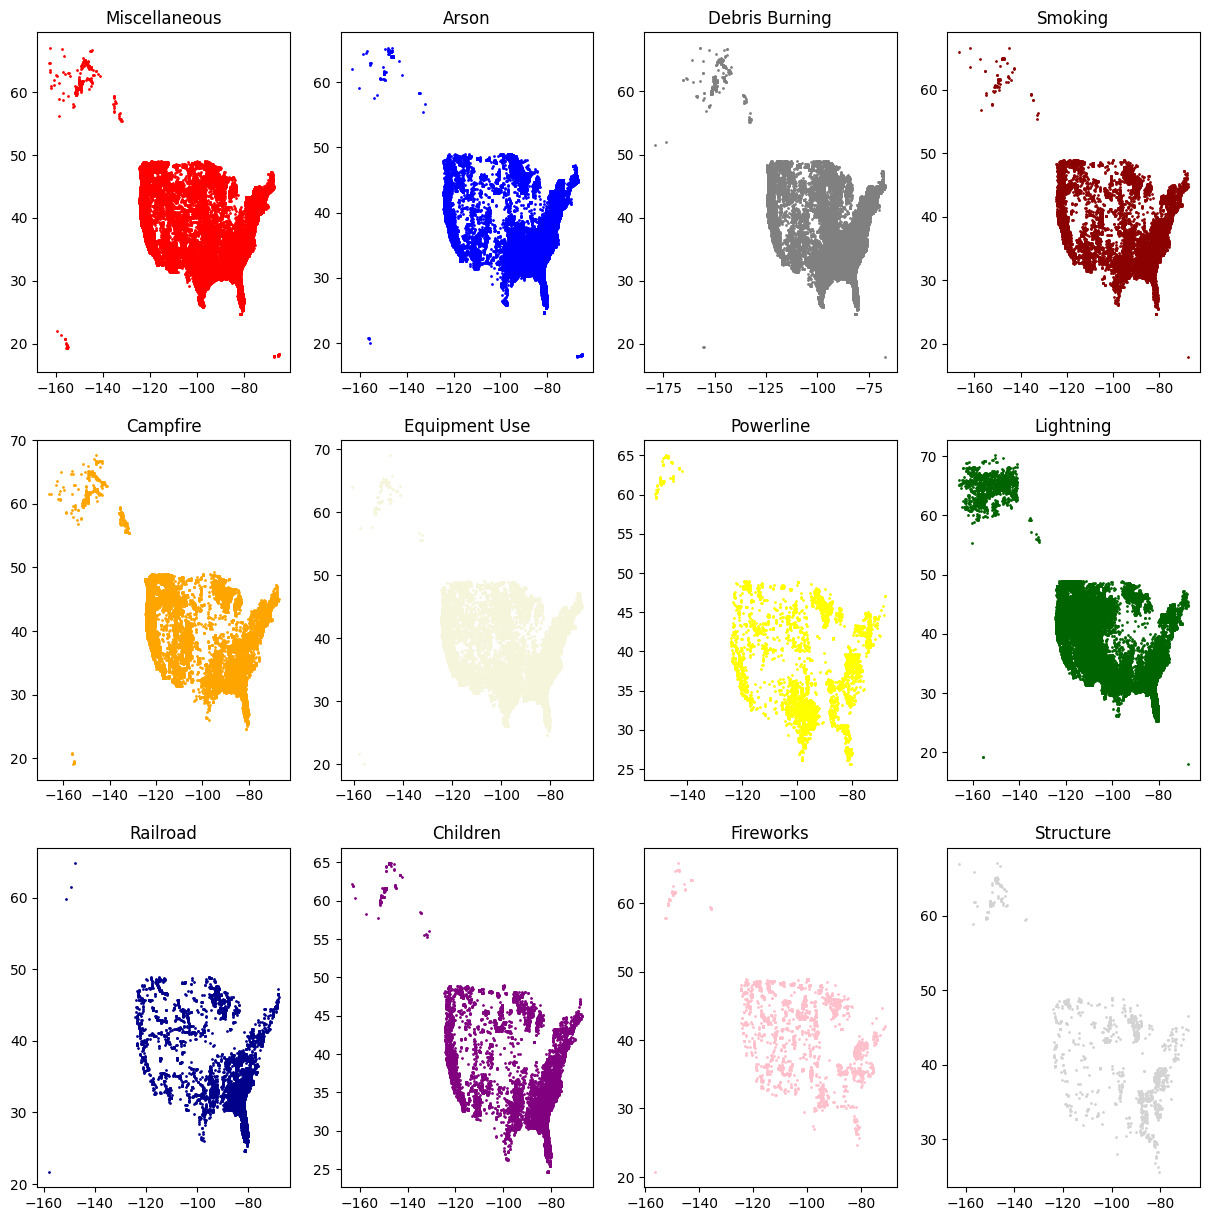

In [140]:
# We give color for each cause to see each cause on a map
colors = ['red', 'blue','gray','darkred','orange', 'beige','yellow', 'darkgreen','darkblue','purple','pink', 'lightgray','green', 'black']
causes = df['STAT_CAUSE_DESCR'].unique()
colors_cause_dic = {causes[i]: colors[i] for i in range(len(causes))}
fig, ax = plt.subplots(3, 4, figsize=(15, 15))
for i, cause in enumerate(colors_cause_dic.keys()):
  row = i//4
  col = i%4
  ax[row, col].scatter(x=df[df['STAT_CAUSE_DESCR'] == cause]['LONGITUDE'],
             y=df[df['STAT_CAUSE_DESCR'] == cause]['LATITUDE'],
             c=colors_cause_dic[cause], label=cause, s=1)
  ax[row, col].set_title(cause)
plt.show()

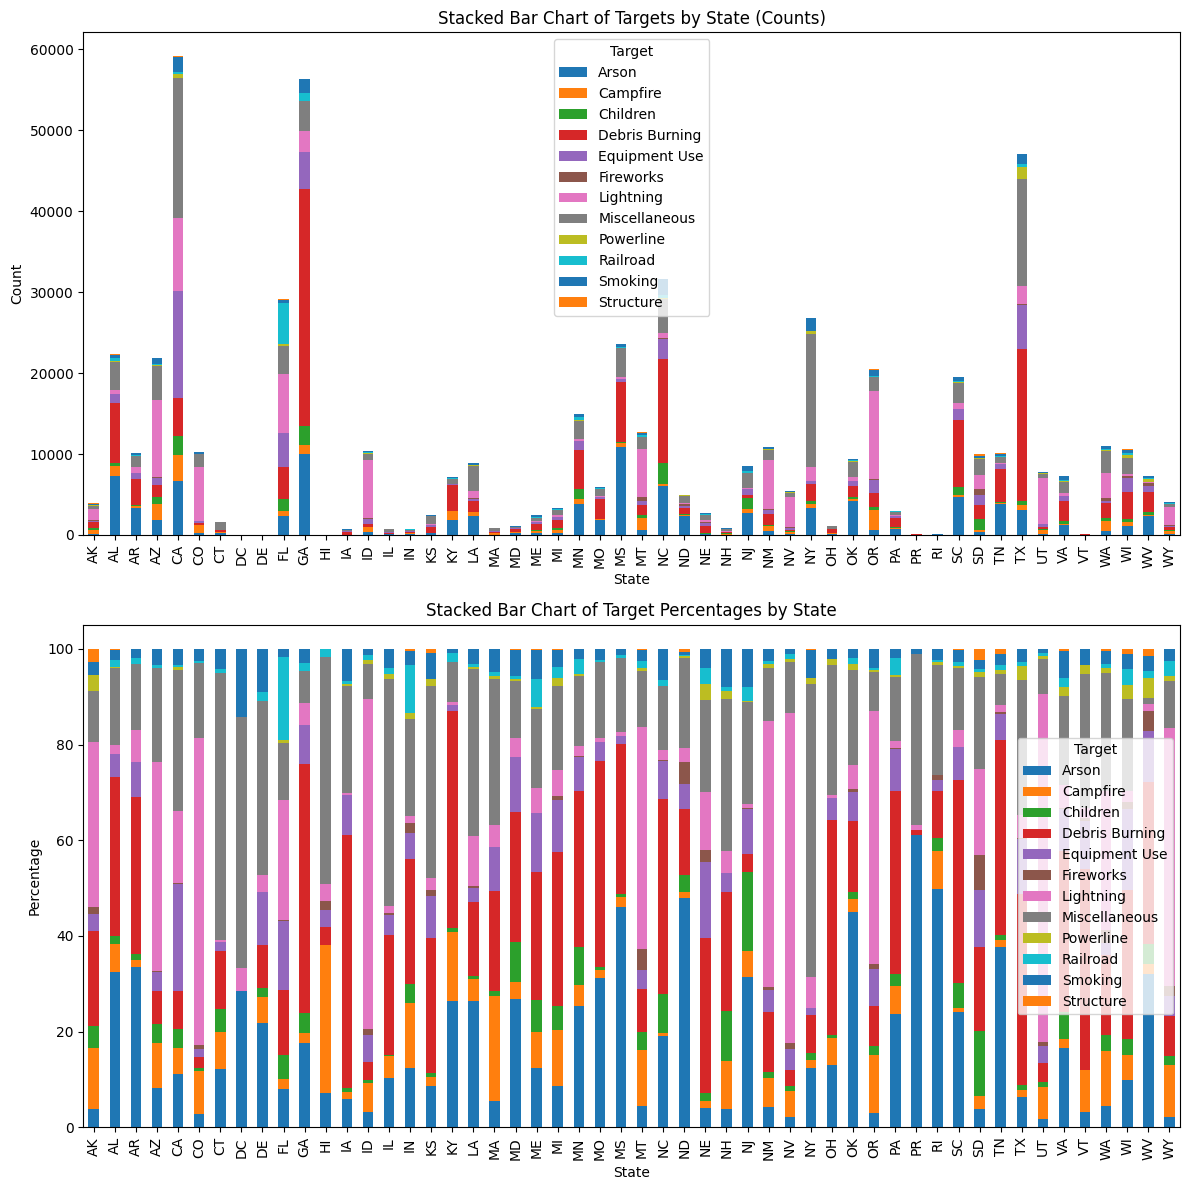

In [141]:
import pandas as pd
import matplotlib.pyplot as plt

# Grouping by 'state' and 'target', then counting occurrences
grouped = df.groupby(['STATE', 'STAT_CAUSE_DESCR']).size().unstack(fill_value=0)

# Calculating percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plotting stacked bar charts
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plotting counts
grouped.plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Stacked Bar Chart of Targets by State (Counts)')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Count')
axes[0].legend(title='Target')
axes[0].tick_params(axis='x', rotation=90)

# Plotting percentages
grouped_percentage.plot(kind='bar', stacked=True, ax=axes[1])
axes[1].set_title('Stacked Bar Chart of Target Percentages by State')
axes[1].set_xlabel('State')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Target')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Now let's see how would state affects the distribution of target classes.

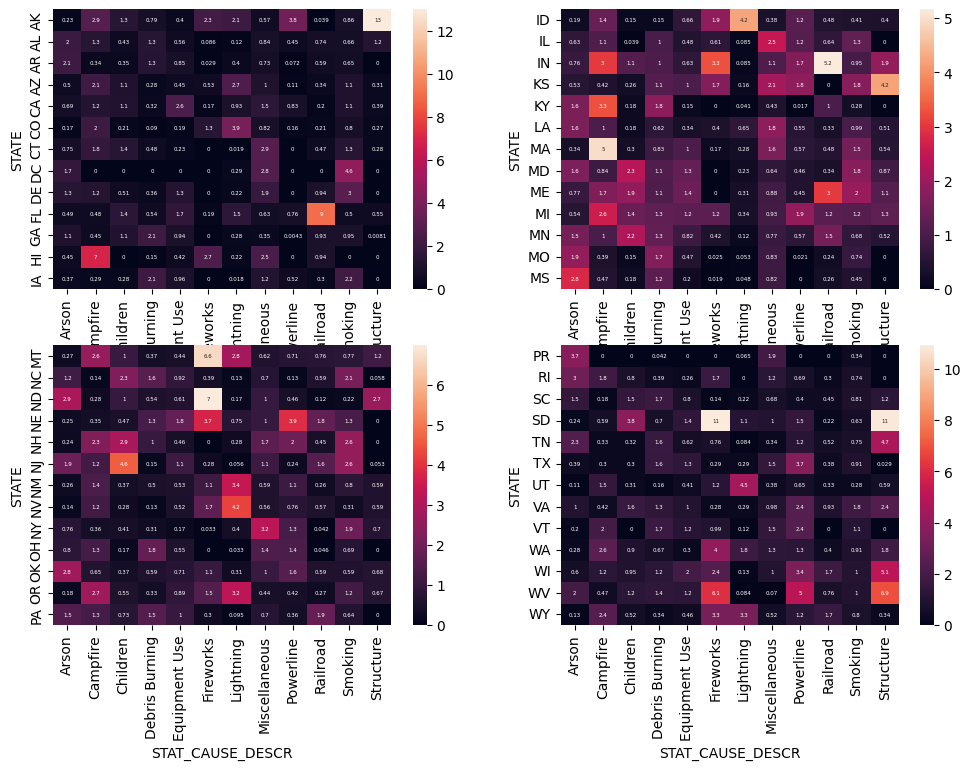

In [142]:
percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
def plot_big_crosstab_vs_original(df, feature_name, n_rows, n_cols):
  # no need input check here: n_rows/cols of the plot, not of dataframe
  total_plots = n_rows * n_cols
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
  cross_Vals = pd.crosstab(df[feature_name], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  axes = axes.flatten()

  for i in range(total_plots):
    start_idx = i * len(cross_Vals) // total_plots
    end_idx = (i + 1) * len(cross_Vals) // total_plots
    subset_df = cross_Vals.iloc[start_idx: end_idx]
    sns.heatmap(subset_df, annot=True, annot_kws={"fontsize":4}, ax=axes[i])
  plt.show()
plot_big_crosstab_vs_original(df, 'STATE', 2, 2)

## Feature Engineering

### Longitude and latitude

Let's just try pass in the numbers and see how much it imporves the result. The result is pretty good. We add another hald percent.  



Now we will cluster the points using DBSCAN, and then calculate the distance of each point to it's nearest cluster. (Distance to centroid of the cluster).  We will do this also group by each target class in the target

In [143]:
from sklearn.cluster import DBSCAN

target_class_clusters = {}
def get_clusters_centroids(df):
  epsilon = 0.5  # maximum distance between points to be considered in the same neighborhood
  min_samples = 5  # minimum number of points in a neighborhood to be considered a core point
  dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
  # now apply DBSCAN
  dbscan.fit(df[['LATITUDE', 'LONGITUDE']])
  # Get the indices of core samples
  core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
  core_samples_mask[dbscan.core_sample_indices_] = True
  # Get the unique cluster labels
  labels = dbscan.labels_
  n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
  # Now Calculate the cluster centroids
  clusters_centroids = []
  for i in range(n_clusters):
      cluster_points = df[['LATITUDE', 'LONGITUDE']][labels == i]
      cluster_center = np.mean(cluster_points, axis=0)
      clusters_centroids.append(cluster_center)
  clusters_centroids = np.array(clusters_centroids)
  return clusters_centroids

def train_target_class_clusters(df):
  for target_class in target_classes:
    df_target_class = df[df['STAT_CAUSE_DESCR']== target_class]
    target_class_clusters[target_class] = get_clusters_centroids(df_target_class)


In [144]:
def encode_dis_to_nearest_centroid(row, target_class):
  clusters_centroids = target_class_clusters[target_class]
  point = [row['LATITUDE'], row['LONGITUDE']]
  cluster_distances = np.linalg.norm(clusters_centroids - point, axis=1)  # Calculate distances to all centroids at once
  min_distance = np.min(cluster_distances)  # Find the minimum distance
  return min_distance



### STATE

During the EDA we found out that being in certain state will affect the distribution of the final label. So what we are going to do is that, for each label, we will find the top k states that is highly correlated to the label, and we will generate a feature that says "is the sample in either of these k states".

In [145]:
state_significance = {}

def train_state_encoders(df):
  # find out for each class which states will have higher than normal percentage of the class instance.
  percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
  cross_Vals = pd.crosstab(df['STATE'], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)

  # For each class, we will encode each state to "how important they are to prediction the class"
  for target_class in target_classes:
    state_significance_per_class = {}
    for state in cross_Vals.index:
      significance = cross_Vals.loc[state, target_class]
      state_significance_per_class[state] = significance
    state_significance[target_class] = state_significance_per_class




Notice here that we could have train one column, comparing whole distribution using kl divergence or something, but I split it up for each class, hoping that this might provide more insight.

### COUNTY

There are some missing values in county. And we can see that county-fip_code-fip_name are being null together.   
Also we can see that county being null have a negative influence on powerline and rail road.  
So what if we pass FIPS_code into frequency encoding?  
Turns out it helped..... I don't even understand why it would help.....


So what if we imputate county by state, and then encode it. See what would happen?  
Turns out if you don't imputate, it preforms better.... XGBoost seems to know how to handle it.....

In [146]:
def encode_geospacial_data(df):
  # encode state
  for target_class in target_classes:
    df['SE-'+ target_class] = df['STATE'].map(state_significance[target_class])

  # encode longitude and latitude
  for target_class in target_classes:
    df['DISTANCE_TO_CLUSTERS-'+target_class] = df.apply(encode_dis_to_nearest_centroid,args=(target_class,), axis=1)
  return df

In [147]:
state_encoding_features = ['SE-' + target_class for target_class in target_classes]
coordinate_encoding_features = ['DISTANCE_TO_CLUSTERS-'+target_class for target_class in target_classes]
geospacial_features = state_encoding_features + ['LATITUDE', 'LONGITUDE'] + coordinate_encoding_features

# Time data

## EDA

We need to make some alternation on the data first in order to show pictures

In [198]:
# save the original df, we will trasform df back later
original_df = df.copy()

In [199]:
# simple reformatting
df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')

# encode month and day of week (weekend or not.) Here we do not use numerical values becasue it might be non ordinal
df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
# notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

# I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

# Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
# And I will both one hot encode it and frequency encode it
df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                        5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                        9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
# For null time data: Discovery time, control date, control time etc.
# encode discovery time
df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

# encode delta time
df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                          format='%Y-%m-%d %H:%M:%S', errors='coerce')


df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                          format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Calculate the time difference
df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()


Let's see how a fire year affects the distribution of the target labels. We first calculate the distribution of the target classes when fixed a year then we use the distribution divided by the original distribution of the target classes.

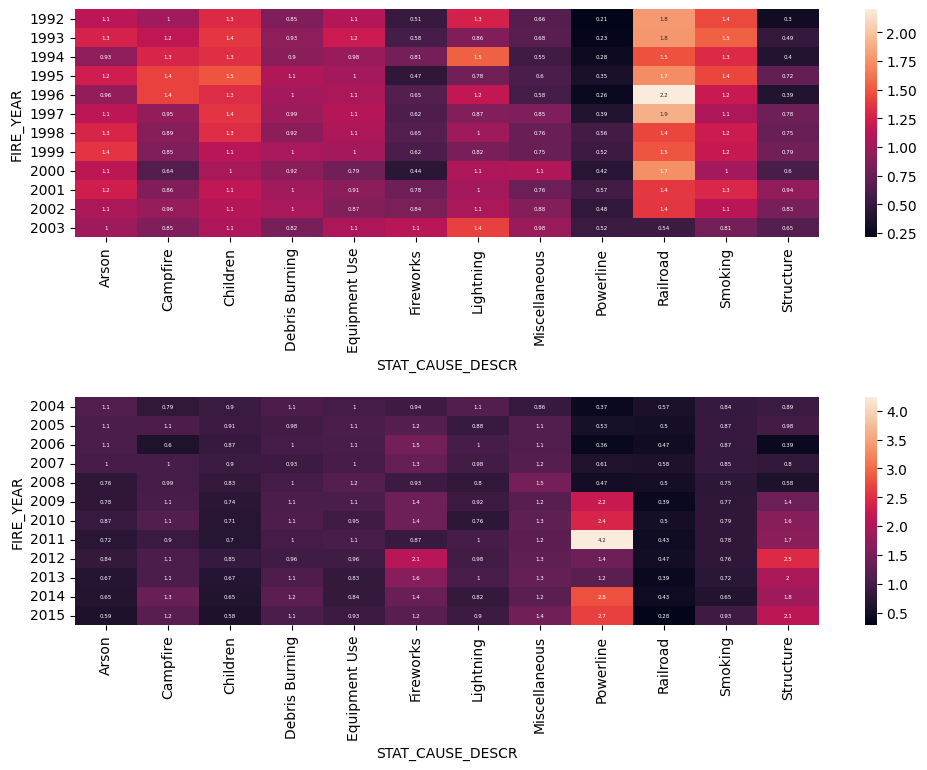

In [218]:
percentage_of_each_label = df['STAT_CAUSE_DESCR'].value_counts(normalize=True)
def plot_big_crosstab_vs_original(df, feature_name, n_rows, n_cols):
  # no need input check here: n_rows/cols of the plot, not of dataframe
  total_plots = n_rows * n_cols
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 8))
  cross_Vals = pd.crosstab(df[feature_name], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  axes = axes.flatten()

  for i in range(total_plots):
    start_idx = i * len(cross_Vals) // total_plots
    end_idx = (i + 1) * len(cross_Vals) // total_plots
    subset_df = cross_Vals.iloc[start_idx: end_idx]
    sns.heatmap(subset_df, annot=True, annot_kws={"fontsize":4}, ax=axes[i])

  # different from the above same function
  plt.subplots_adjust(hspace=0.7, wspace=0.5)

  plt.show()
plot_big_crosstab_vs_original(df, 'FIRE_YEAR', 2, 1)

Let's see number of fires by month and day of week

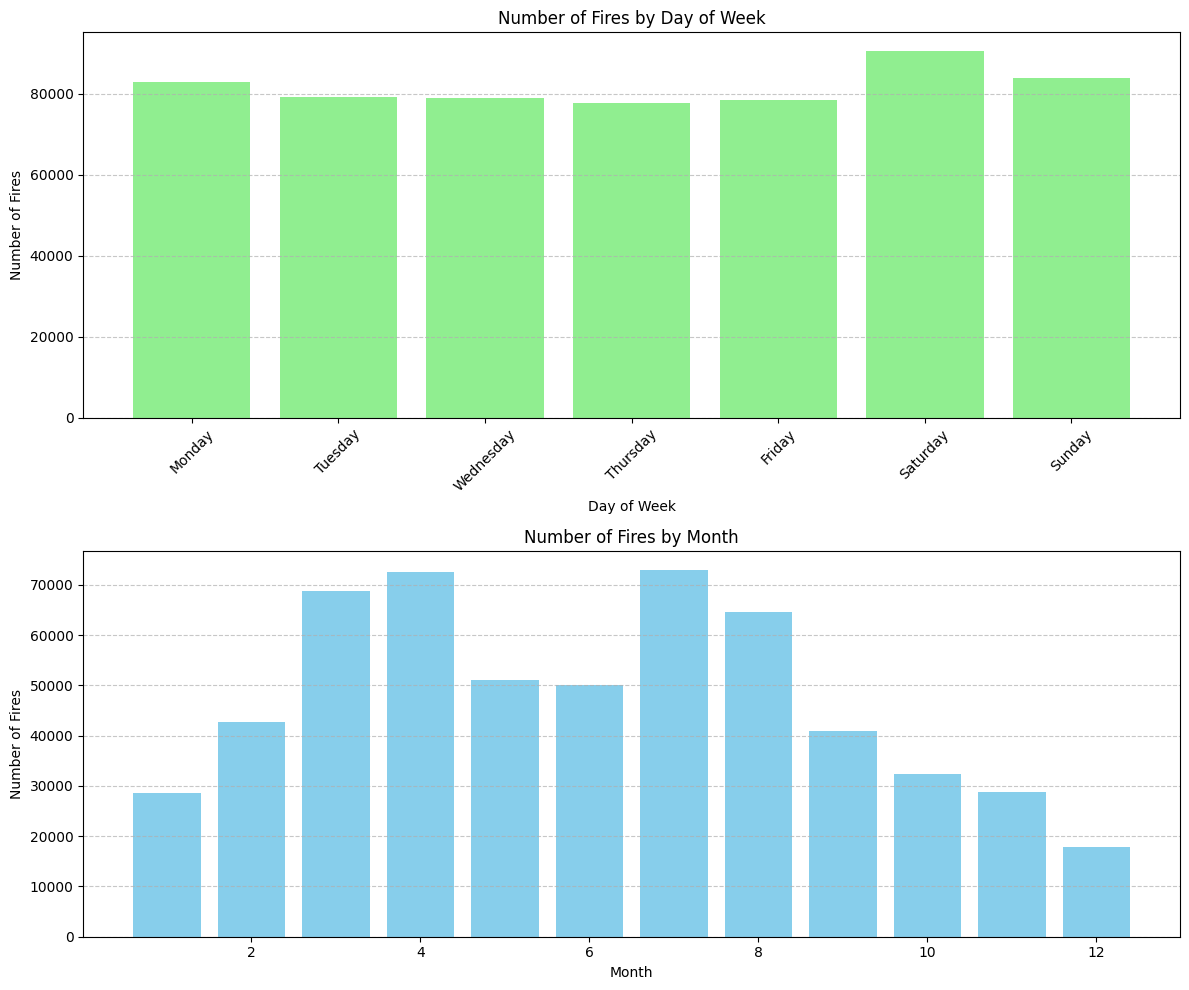

In [201]:
# Plotting the graph
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))



df['day_of_week'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.dayofweek
day_of_week_counts = df.groupby('day_of_week').size()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

axes[0].bar(range(7), day_of_week_counts, color='lightgreen')
axes[0].set_title('Number of Fires by Day of Week')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Number of Fires')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(day_names, rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

df['month'] = pd.to_datetime(df['DISCOVERY_DATE']).dt.month
monthly_counts = df.groupby('month').size()
axes[1].bar(monthly_counts.index, monthly_counts, color='skyblue')
axes[1].set_title('Number of Fires by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Fires')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Let's first see how does month affects the distribution of each target class.

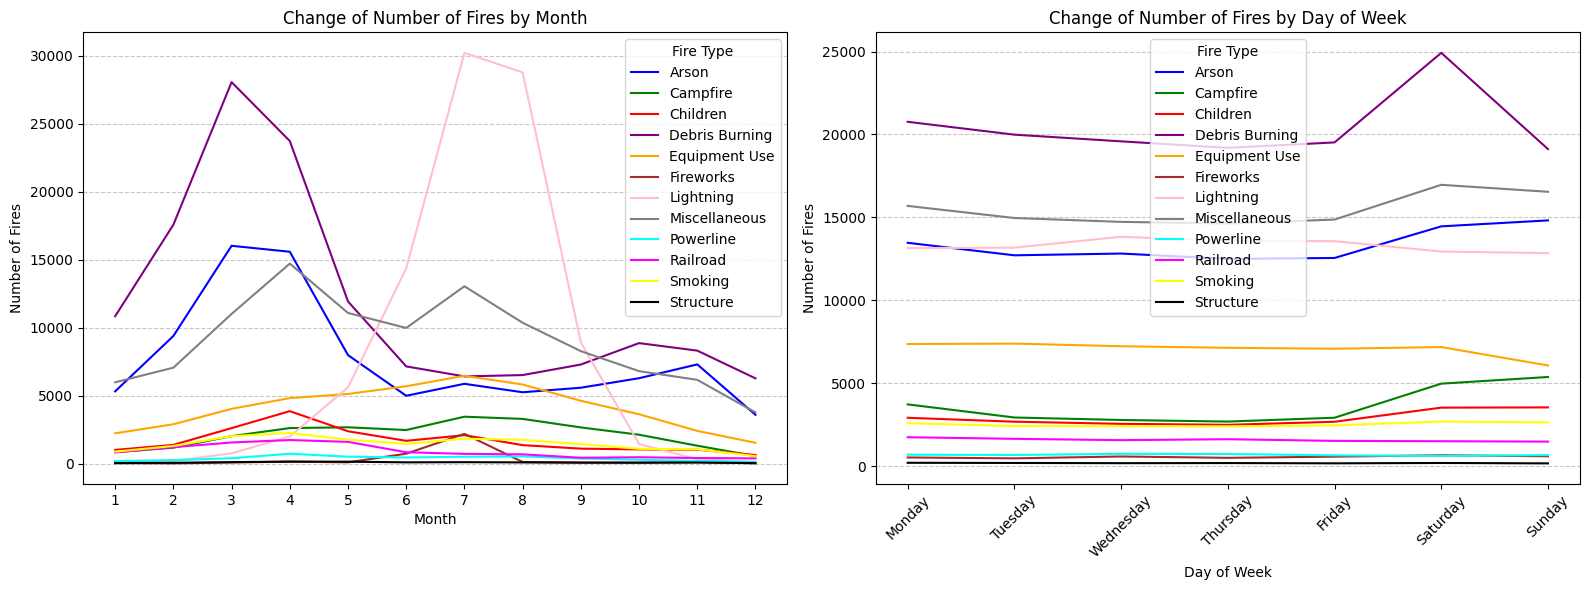

In [202]:
import pandas as pd
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow', 'black']

grouped_monthly = df.groupby(['STAT_CAUSE_DESCR', 'month']).size().unstack(fill_value=0)
for i, fire_type in enumerate(grouped_monthly.index):
    axes[0].plot(grouped_monthly.columns, grouped_monthly.loc[fire_type], label=fire_type, color=colors[i])

axes[0].set_title('Change of Number of Fires by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Fires')
axes[0].set_xticks(range(1, 13))
axes[0].legend(title='Fire Type')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

grouped_daily = df.groupby(['STAT_CAUSE_DESCR', 'day_of_week']).size().unstack(fill_value=0)
for i, fire_type in enumerate(grouped_daily.index):
    axes[1].plot(grouped_daily.columns, grouped_daily.loc[fire_type], label=fire_type, color=colors[i])

axes[1].set_title('Change of Number of Fires by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Fires')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=45)
axes[1].legend(title='Fire Type')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

We can look at how month affects the distribution of target classes

In [208]:
def plot_crosstab_heatmap_vs_original(df, feature_name, axes=None):
  cross_Vals = pd.crosstab(df[feature_name], df['STAT_CAUSE_DESCR'],  normalize='index')
  cross_Vals = cross_Vals.div(percentage_of_each_label, axis=1)
  if axes is None:
    sns.heatmap(cross_Vals, annot=True, annot_kws={"fontsize":4})
  else:
    sns.heatmap(cross_Vals, annot=True, annot_kws={"fontsize":4}, ax=axes)


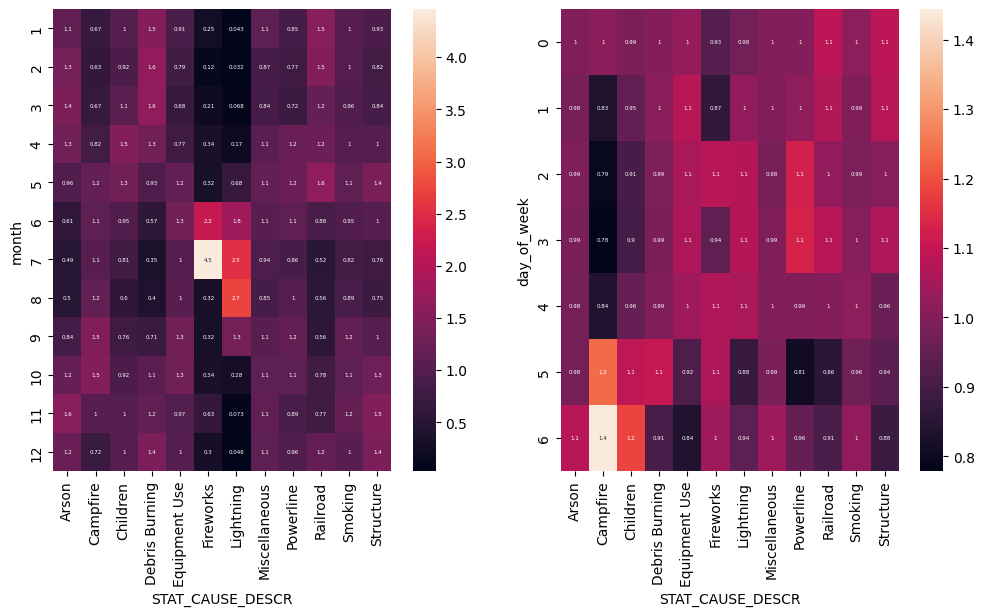

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
plot_crosstab_heatmap_vs_original(df, 'month', axes[0])
plot_crosstab_heatmap_vs_original(df, 'day_of_week', axes[1])
plt.show()

Now let's look at how exactly each target class increases or decreases in every day of the year

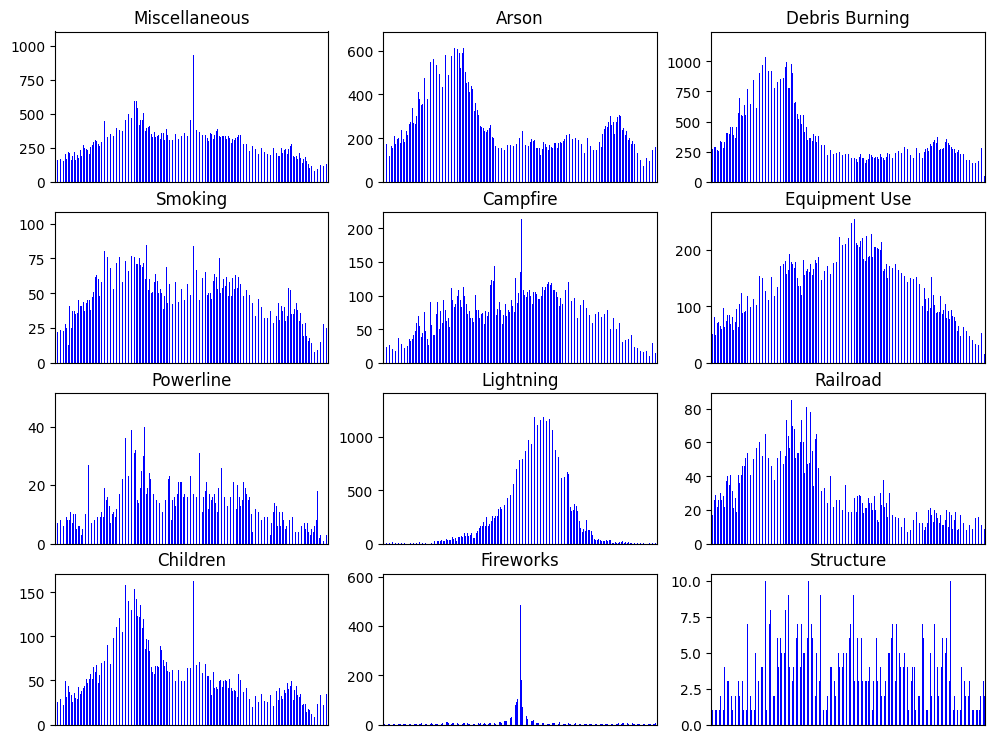

In [221]:
# Create a figure and axes for the subplots
fig, axes = plt.subplots(4, 3, figsize=(12, 9))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, target_class in enumerate(target_classes):
  target_class_df = df[df['STAT_CAUSE_DESCR'] == target_class]
  target_class_counts = target_class_df.groupby(df['DISCOVERY_DOY']).size()
  target_class_counts.plot(kind='bar', color='blue', ax=axes[i])
  axes[i].set_title(target_class)
  axes[i].set_xticks([])
  axes[i].set_xlabel('')


plt.show()

Let's zoom in to july

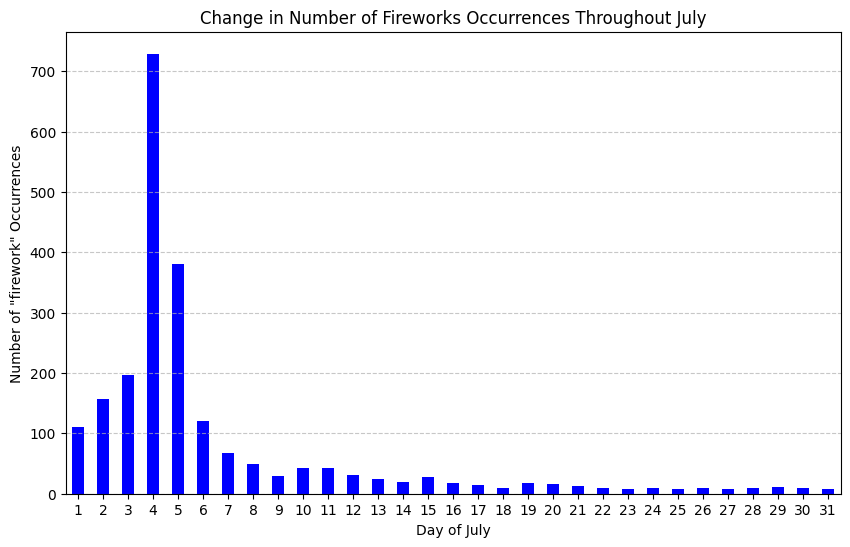

In [222]:
# Filter the data for the month of July
july_data = df[df['DISCOVERY_DATE'].dt.month == 7]

# Filter the data for rows where the 'cause' column is 'firework'
firework_data = july_data[july_data['STAT_CAUSE_DESCR'] == 'Fireworks']

# Group by date and count the occurrences of 'firework'
firework_counts = firework_data.groupby(firework_data['DISCOVERY_DATE'].dt.day).size()
# Plot the change in the number of 'firework' occurrences throughout July
plt.figure(figsize=(10, 6))
firework_counts.plot(kind='bar', color='blue')
plt.xlabel('Day of July')
plt.ylabel('Number of "firework" Occurrences')
plt.title('Change in Number of Fireworks Occurrences Throughout July')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

So july the fourth is the problem here

Now let's look at how discovery hour affect the distribution

In [ ]:
df =  df.dropna(subset=['DISCOVERY_TIME'])
plot_crosstab_heatmap_vs_original(df, 'DISCOVERY_HOUR')

## Feature Engineering

### Date, Month, Season

Let's first convert the time to the right format

From EDA we have seen that season, month and day of week really affects the final prediction. So we will add in this data.

The first thing we want to check is the obvious ones:  Firework on July the forth. Alone with Miscellaneous, Children and Campfire.

The second thing is we can see that Arson, debris buring, railroad and children have more instances in april. While Lighning and equipment use have more instances in July. Maybe I should try one hot encoding and frequency encoding on month and season.

We also looked at FIRE_YEAR

Little note here: if we have more time, we can see the correlation between two joint features: (feature_1 = a X feature_2 = b). To be more precise: Summer in Alaska. Somethings like this.   
Another little note, I was planning to put some catagorical data in for XGBoost to do some one hot embedding, but turns out that some fatures (season) will make the overall performance lowers.....  
One more thing we can do is preform a cyclic transformation of week of day or even day of year.

In [ ]:
import numpy as np

def time_encoding(df):
  # simple reformatting
  df['DISCOVERY_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['DISCOVERY_TIME'] = pd.to_datetime(df['DISCOVERY_TIME'], format='%H%M', errors='coerce')
  df['CONT_DATE']= pd.to_datetime(df['CONT_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
  df['CONT_TIME'] = pd.to_datetime(df['CONT_TIME'], format='%H%M', errors='coerce')
  # encode independence day
  df['independence_day'] = (df['DISCOVERY_DATE'].dt.month == 7) & (df['DISCOVERY_DATE'].dt.day.isin([4, 5]))

  # encode month and day of week (weekend or not.)
  df['MONTH'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%B')
  df['DAY_OF_WEEK'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).strftime('%A')
  # notice that these two columns will be frequency encoded in the later section. So the later section depends on the execution of this section.

  # I want to pass fire year as a catagory, just like month and day of week, for onhot encoding
  df['FIRE_YEAR'] = df['FIRE_YEAR'].astype('category')

  # Now I want to see if I can stuff in one more thing: Season. Basically a combination of months.
  # And I will both one hot encode it and frequency encode it
  df['SEASON'] = pd.DatetimeIndex(df['DISCOVERY_DATE']).month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                                          5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                                          9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})
  # For null time data: Discovery time, control date, control time etc.
  # encode discovery time
  df['DISCOVERY_HOUR'] = df['DISCOVERY_TIME'].dt.hour

  # encode delta time
  df['DISCOVERY_DATETIME'] = pd.to_datetime(df['DISCOVERY_DATE'].astype(str) + ' ' + df['DISCOVERY_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')


  df['CONT_DATETIME'] = pd.to_datetime(df['CONT_DATE'].astype(str) + ' ' + df['CONT_TIME'].dt.time.astype(str),
                                            format='%Y-%m-%d %H:%M:%S', errors='coerce')

  # Calculate the time difference
  df['DELTA_TIME'] = (df['CONT_DATETIME'] - df['DISCOVERY_DATETIME']).dt.total_seconds()

  # Cyclic transformation for DOY, Month, Week, Hour
  df['SIN_DISCOVERY_DOY'] = np.sin(2*np.pi*df['DISCOVERY_DOY']/366)
  df['COS_DISCOVERY_DOY'] = np.cos(2*np.pi*df['DISCOVERY_DOY']/366)

  df['SIN_MONTH'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)
  df['COS_MONTH'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).month/12)

  df['SIN_DAY_OF_WEEK'] = np.sin(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)
  df['COS_DAY_OF_WEEK'] = np.cos(2*np.pi*pd.DatetimeIndex(df['DISCOVERY_DATE']).dayofweek/7)

  df['SIN_HOUR'] = np.sin(2*np.pi*df['DISCOVERY_HOUR']/24)
  df['COS_HOUR'] = np.cos(2*np.pi*df['DISCOVERY_HOUR']/24)

  return df

turns out imputation doesnot affect it at all. We are going to do it anyways, because we want to run other models to see results.

In [ ]:
encoded_time_data = ['independence_day', 'MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'DISCOVERY_HOUR', 'DELTA_TIME',
                     'SIN_DISCOVERY_DOY', 'COS_DISCOVERY_DOY', 'SIN_MONTH', 'COS_MONTH',
                     'SIN_DAY_OF_WEEK', 'COS_DAY_OF_WEEK', 'SIN_HOUR', 'COS_HOUR']

### Null Time Data

It seems like some of the descovery time and contained time are null. In order to solve this problem, denote delta_time = contained_time - discover_time. We can see that there are correlation between delta_time and fire_size, so maybe we can try to imputate this value.   
In EDA, we can see that descovery time and contained time being null have high correlation. So if both time is mising, we can try to drop the rows, and see what would happen.

It seems like if not drop null rows, XGBoost will preform slightly better by fill in the blank by itself.

Now there are two thing we want to do, first, we want to encode the discovery_time, and then we want to calculate delta time.  
I am thinking for starters, I will encode the discovery time into hours of the day, and preform a cyclic transformation.

The observation is, cyclic transformation on hour doesnot really help with accuracy.

Let's first try to see if we just pass in DISCOVERY_HOUR and DELTA_TIME, what would happen.   
Turns out it helps the model by a little bit.

Finally to add something, we will just add cyclic transformation for DOY, MONTH, Week, Hour, and see what happens

And one more thing: we will imputate the DELTA_TIME by the average of the fire size class. See why below:

Let's show the relationship between delta time and FIRE_SIZE and FIRE_SIZE_CLASS

In [ ]:
feature1 = 'FIRE_SIZE'
feature2 = 'DELTA_TIME'

plt.figure(figsize=(8, 6))
plt.scatter(df[feature1], df[feature2], alpha=0.5)
plt.title(f'Scatter Plot of {feature1} vs {feature2}')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.grid(True)
plt.show()

In [ ]:
feature3 = 'FIRE_SIZE_CLASS'

grouped_data = df.groupby(feature3)[feature2].agg(['mean']).reset_index()

# Plot bar chart for each category
plt.bar(grouped_data[feature3], grouped_data['mean'])

plt.title(f'Mean and Variance of {feature3} by {feature3}')
plt.xlabel(feature3)
plt.ylabel('Value')
plt.show()

Result is: inputate delta time doesnot realy help or harm the performance.

Remeber to return df to original

In [ ]:
df = original_df.copy()

# Catagorical

## EDA

Let's look at how each class affects the distribution of the target classes, in order to determin if they are worth encoding.

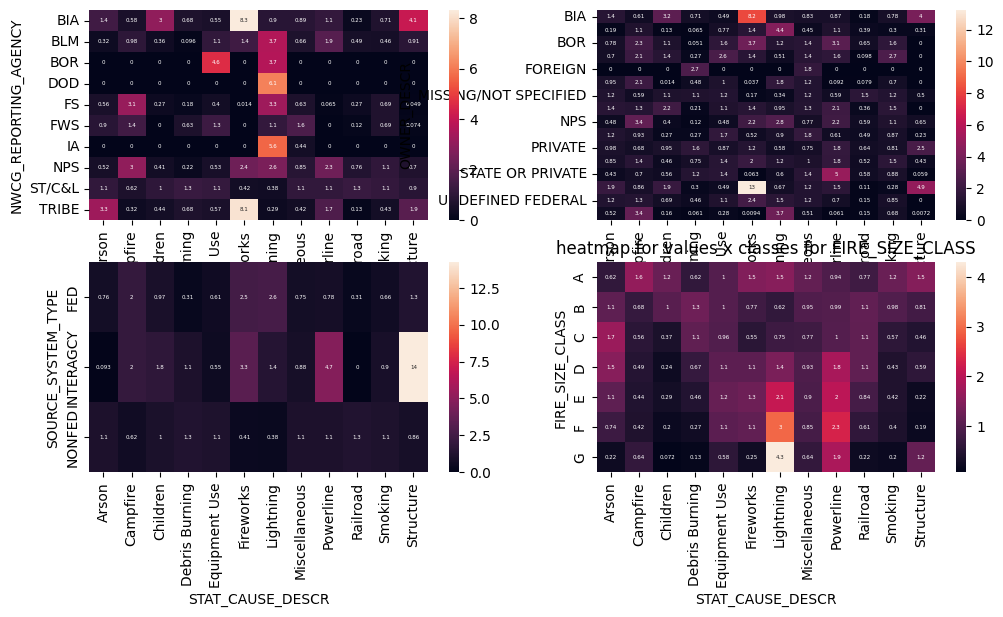

In [163]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

plot_crosstab_heatmap_vs_original(df, 'NWCG_REPORTING_AGENCY', axes[0,0])
plot_crosstab_heatmap_vs_original(df, 'OWNER_DESCR', axes[0,1])
plot_crosstab_heatmap_vs_original(df, 'SOURCE_SYSTEM_TYPE', axes[1,0])
plot_crosstab_heatmap_vs_original(df, 'FIRE_SIZE_CLASS', axes[1, 1])
plt.show()

## Feature Engineering

### Frequency Encoding

We will train an encoder based on the training set, and then use it to encode both training set and evaluation set

We will try to use frequency encoding for every thing. Except for null columns and states.

In [164]:
# These are High cardinality catagorical features
HC_features = ['NWCG_REPORTING_UNIT_ID', 'NWCG_REPORTING_UNIT_NAME',
               'SOURCE_REPORTING_UNIT', 'SOURCE_REPORTING_UNIT_NAME']
LC_features = ['FIRE_SIZE_CLASS',
                'NWCG_REPORTING_AGENCY',
                'OWNER_CODE', 'OWNER_DESCR',
                'SOURCE_SYSTEM', 'SOURCE_SYSTEM_TYPE',]
catagorical_time_data = ['MONTH', 'DAY_OF_WEEK', 'FIRE_YEAR', 'SEASON', 'DISCOVERY_HOUR']
catagorical_geospacial_data = ['STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME']
catagorical_features = HC_features + LC_features + catagorical_time_data + catagorical_geospacial_data

In [165]:
#  generic function for frequency encoding
frequency_encoder_map = {}
def train_frequency_encoders(df):
  for feature in catagorical_features:
    frequency_encoder = df[feature].value_counts(normalize=True)
    frequency_encoder_map[feature] = frequency_encoder

def frequency_encoding(df):
  for feature in catagorical_features:
    df['FE-'+ feature] = df[feature].map(frequency_encoder_map[feature])
  return df

Little note here: if just simply pass catagorical data to to XGB will not make it better. I am assuming XGB is using one hot embedding.

# Numerical

## EDA

In [166]:
df.describe()

OBJECTID        FOD_ID      FIRE_YEAR  DISCOVERY_DATE  \
count  5.714250e+05  5.714250e+05  571425.000000    5.714250e+05   
mean   9.266425e+05  5.152594e+07    2003.697939    2.453061e+06   
std    5.423844e+05  9.880682e+07       6.629826    2.422181e+03   
min    1.000000e+00  1.000000e+00    1992.000000    2.448622e+06   
25%    4.370660e+05  4.711850e+05    1998.000000    2.451140e+06   
50%    9.492000e+05  1.076819e+06    2004.000000    2.453104e+06   
75%    1.388606e+06  1.908442e+07    2009.000000    2.455036e+06   
max    1.880465e+06  3.003484e+08    2015.000000    2.457388e+06   

       DISCOVERY_DOY  DISCOVERY_TIME     CONT_DATE       CONT_DOY  \
count  571425.000000   314476.000000  3.059020e+05  305902.000000   
mean      166.302769     1452.604940  2.453324e+06     174.615566   
std        89.574131      405.494339  2.630582e+03      83.517623   
min         1.000000        0.000000  2.448622e+06       1.000000   
25%        92.000000     1239.000000  2.451036e+06     105.000000   
50%       167.000000     1458.000000  2.453550e+06     183.000000   
75%       231.000000     1708.000000  2.455764e+06     233.000000   
max       366.000000     2359.000000  2.457388e+06     366.000000   

           CONT_TIME      FIRE_SIZE       LATITUDE      LONGITUDE  \
count  286814.000000  571425.000000  571425.000000  571425.000000   
mean     1540.321658      72.818371      37.101224     -95.785956   
std       432.277391    2261.190807       5.784236      15.928370   
min         0.000000       0.000010      17.939722    -178.802600   
25%      1320.000000       0.100000      32.868195    -110.133100   
50%      1600.000000       1.000000      35.605000     -92.254700   
75%      1814.000000       3.000000      41.033200     -82.566000   
max      2359.000000  537627.000000      70.138100     -65.275556   

          OWNER_CODE      FIPS_CODE  
count  571425.000000  359205.000000  
mean       10.364897      99.875389  
std         4.479953     101.849369  
min         0.000000       1.000000  
25%         8.000000      29.000000  
50%        14.000000      69.000000  
75%        14.000000     125.000000  
max        15.000000     810.000000

Let's look at how fire size is distributed among class

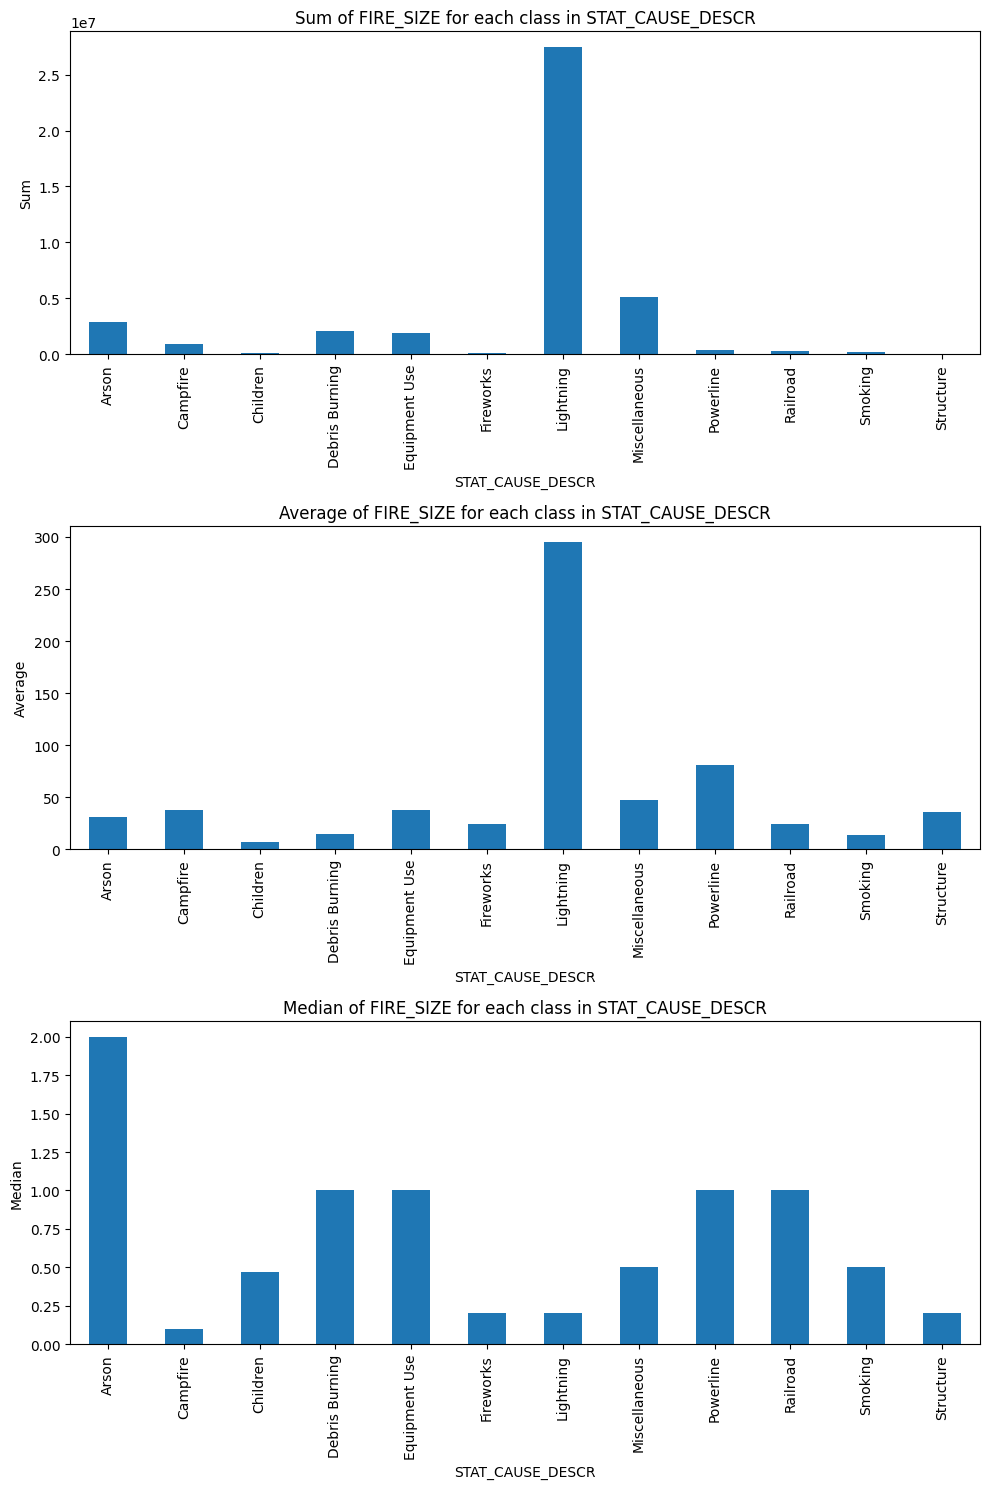

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
# Group by 'feature_1' and calculate sum, average, and median of 'feature_2' within each group
grouped_df = df.groupby('STAT_CAUSE_DESCR')['FIRE_SIZE'].agg(['sum', 'mean', 'median'])

# Create a figure and subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot sum of 'feature_2'
grouped_df['sum'].plot(kind='bar', ax=axes[0])
axes[0].set_title('Sum of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[0].set_ylabel('Sum')

# Plot average of 'feature_2'
grouped_df['mean'].plot(kind='bar', ax=axes[1])
axes[1].set_title('Average of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[1].set_ylabel('Average')

# Plot median of 'feature_2'
grouped_df['median'].plot(kind='bar', ax=axes[2])
axes[2].set_title('Median of FIRE_SIZE for each class in STAT_CAUSE_DESCR')
axes[2].set_ylabel('Median')

plt.tight_layout()
plt.show()

It seems like there is a correlation between size of fire to the target class, so we will keep it.

# Additional information

In [169]:
df_stormevents = pd.read_csv('/content/drive/MyDrive/Projects/FirePrediction/storm_events.csv',index_col=0)

In [170]:
# train storm encoder, we will just look at first day of storm
df_stormevents['BEGIN_DATE'] = pd.to_datetime(df_stormevents['BEGIN_DATE'])
storm_by_state = df_stormevents.groupby(['BEGIN_DATE', 'STATE']).groups.keys()

def encode_storm_data(df):
  df['STORM'] = False
  df['STORM'] = df.apply(lambda row: (row['DISCOVERY_DATE'],
                                    row['STATE']) in storm_by_state if row['STATE'] else None, axis=1)
  return df

First try just add in FIRE_SIZE and see what happens: It doesn't help much, we will keep it. Taking the log doesnot really improve it either.

# Leakage

Leakage are information that we are not suppose to know during prediction. From data set description, we can determin that there are some columns is either leakage or useless. They should contribute to prediction. So we will not use these columns.  


Firstly, OBJECTID, FOD_ID and FPA_ID are irrelavent features, because they are id used to track samples in database. We can see that they are somehow correlated to other features, but we are not suppose to know the id before the sample is stored in the database. So we will consider this a leakage.

<Axes: >

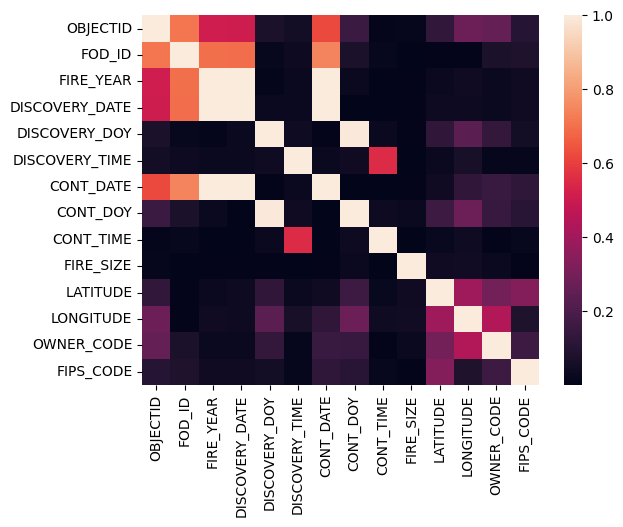

In [171]:
numerical_columns = ['OBJECTID','FOD_ID', 'FIRE_YEAR','DISCOVERY_DATE',
               'DISCOVERY_DOY',	'DISCOVERY_TIME',	'CONT_DATE',	'CONT_DOY',
               'CONT_TIME',	'FIRE_SIZE',	'LATITUDE',	'LONGITUDE','OWNER_CODE','FIPS_CODE']
df_for_correlation = df[numerical_columns]
sns.heatmap(df_for_correlation.corr().abs())

Then we will not use FIRE_NAME and FIRE_CODE since from the description of this two columns, we are not suppose to know the fire name or fire code at the time of prediction.

# Anomaly detection

We will just do a short anomoly detection here. We will look at fire size

In [172]:
import matplotlib.pyplot as plt

def plot_mean_variance_by_category(feature1, feature3, df, rotate_x_lable=False):
    # Group data by categories of feature3 and calculate mean and variance for each group
    grouped_data = df.groupby(feature3)[feature1].agg(['mean', 'std']).reset_index()

    # Plot bar chart for each category
    plt.bar(grouped_data[feature3], grouped_data['mean'], yerr= grouped_data['std'])

    plt.title(f'Mean and Variance of {feature1} by {feature3}')
    if rotate_x_lable == True:
      plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature3)
    plt.ylabel('Value')
    plt.show()

def plot_box_plot(feature1, feature3, df, rotate_x_lable=False):
    df.boxplot(column=feature1, by=feature3)

    plt.title(f'Mean and Variance of {feature1} by {feature3}')
    if rotate_x_lable == True:
      plt.xticks(rotation=45, ha='right')
    plt.xlabel(feature3)
    plt.ylabel('Value')
    plt.show()

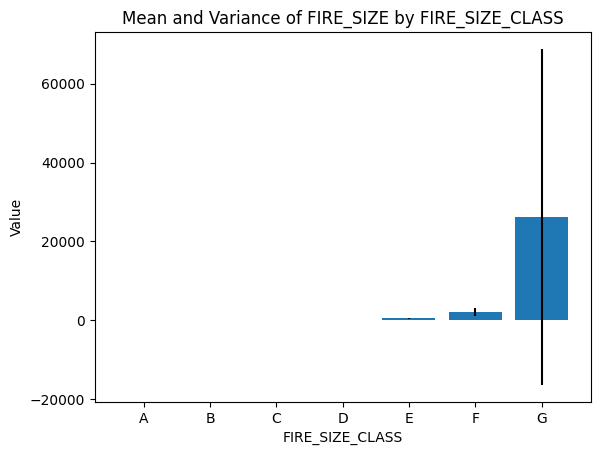

In [173]:
plot_mean_variance_by_category('FIRE_SIZE', 'FIRE_SIZE_CLASS', df)

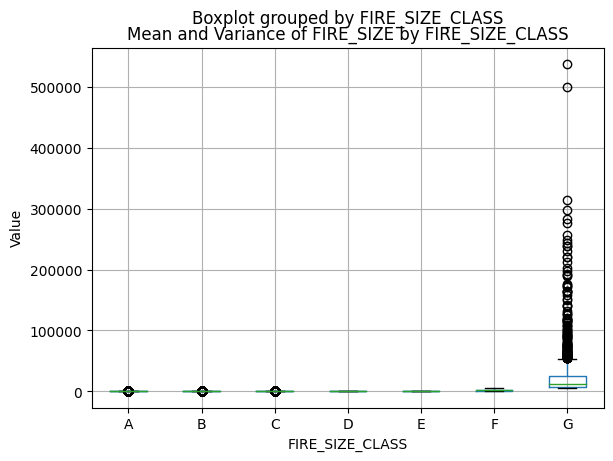

In [174]:
plot_box_plot('FIRE_SIZE', 'FIRE_SIZE_CLASS', df)

We can see that the variance is huge, and there are a lot of fliers. Let's try to get rid of these fliers

In [175]:
def drop_outliers(df):
  non_outlier_list = []
  for fire_size_class in df['FIRE_SIZE_CLASS'].unique():
    df_by_fire_size = df[df['FIRE_SIZE_CLASS']==fire_size_class]
    # Step 1: Calculate Q1 and Q3
    Q1 = df_by_fire_size['FIRE_SIZE'].quantile(0.25)
    Q3 = df_by_fire_size['FIRE_SIZE'].quantile(0.75)

    # Step 2: Calculate IQR
    IQR = Q3 - Q1

    # Step 3: Define threshold for outliers
    threshold = 1.5

    # Step 4: Identify outliers
    non_outlier = df_by_fire_size[(df_by_fire_size['FIRE_SIZE'] >= Q1 - threshold * IQR) & (df_by_fire_size['FIRE_SIZE'] <= Q3 + threshold * IQR)]
    non_outlier_list.append(non_outlier)
  df_non_outlier = pd.concat(non_outlier_list)
  return df_non_outlier

In [176]:
df_non_outlier = drop_outliers(df)

And let's see the fire size afterwards

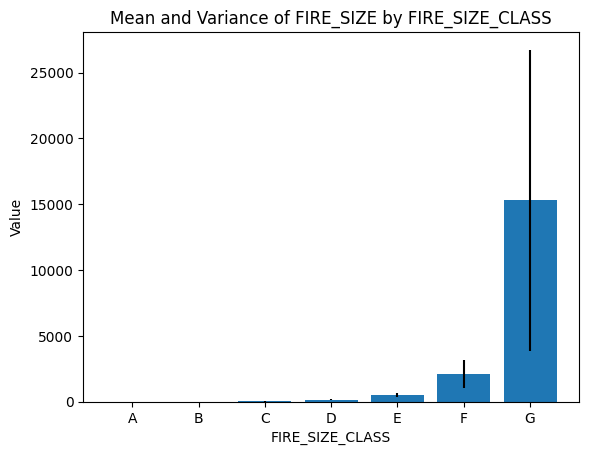

In [177]:
plot_mean_variance_by_category('FIRE_SIZE', 'FIRE_SIZE_CLASS', df_non_outlier)

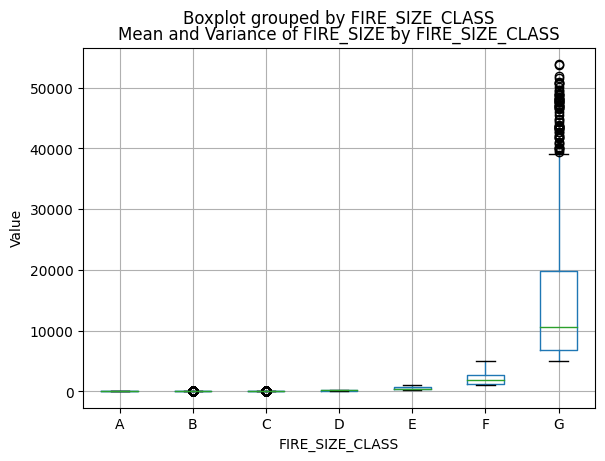

In [178]:
plot_box_plot('FIRE_SIZE', 'FIRE_SIZE_CLASS', df_non_outlier)

Let's see how would this affect the result. The result is that it doesn't really helped, it decreased the accuracy by a little. Se we will not keep this.

# Balancing Data

## EDA

We can see that the data is imbalanced

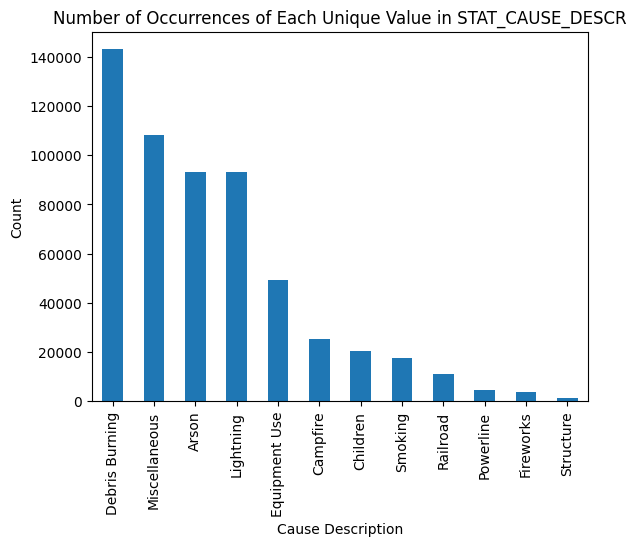

In [179]:
df['STAT_CAUSE_DESCR'].value_counts().plot(kind='bar')

# Add labels and title
plt.title('Number of Occurrences of Each Unique Value in STAT_CAUSE_DESCR')
plt.xlabel('Cause Description')
plt.ylabel('Count')

# Show the plot
plt.show()

We notice that smoke is not preforming well, however, smoke have many samples. So this is not a matter of imbalance. But we will try to balance data and see how would things behave.

In [180]:
import numpy as np
def calculate_sample_weights(y_train):
  class_counts = np.bincount(y_train)
  total_example = np.sum(class_counts)
  class_weights = total_example/(len(class_counts)* class_counts)
  sample_weights = class_weights[y_train]
  return sample_weights

# Null columns

## EDA

In [181]:
column_stats = []
for column_name in df.columns:
    column = df[column_name]
    num_null = column.isnull().sum()
    total_values = len(column)
    null_percent = (num_null / total_values) * 100
    num_of_unique_values = len(column.unique())
    column_stats.append((column_name, num_null, null_percent,num_of_unique_values))

column_stats_df = pd.DataFrame(column_stats, columns=['ColumnName', 'NullNumber', 'NullPercentage', "UniqueValueNumber"])
column_stats_df

ColumnName  NullNumber  NullPercentage  UniqueValueNumber
0                     OBJECTID           0        0.000000             571425
1                       FOD_ID           0        0.000000             571425
2                       FPA_ID           0        0.000000             571425
3           SOURCE_SYSTEM_TYPE           0        0.000000                  3
4                SOURCE_SYSTEM           0        0.000000                 32
5        NWCG_REPORTING_AGENCY           0        0.000000                 10
6       NWCG_REPORTING_UNIT_ID           0        0.000000               1345
7     NWCG_REPORTING_UNIT_NAME           0        0.000000               1341
8        SOURCE_REPORTING_UNIT           0        0.000000               4124
9   SOURCE_REPORTING_UNIT_NAME           0        0.000000               3611
10        LOCAL_FIRE_REPORT_ID      432577       75.701448               5308
11           LOCAL_INCIDENT_ID      235150       41.151507             198416
12                   FIRE_CODE      465326       81.432559              63942
13                   FIRE_NAME      280832       49.145907             184275
14     ICS_209_INCIDENT_NUMBER      563796       98.664917               7019
15                ICS_209_NAME      563797       98.665092               6563
16                     MTBS_ID      568015       99.403246               3326
17              MTBS_FIRE_NAME      568015       99.403246               2862
18                COMPLEX_NAME      569704       99.698823                804
19                   FIRE_YEAR           0        0.000000                 24
20              DISCOVERY_DATE           0        0.000000               8765
21               DISCOVERY_DOY           0        0.000000                366
22              DISCOVERY_TIME      256949       44.966356               1441
23            STAT_CAUSE_DESCR           0        0.000000                 12
24                   CONT_DATE      265523       46.466815               8720
25                    CONT_DOY      265523       46.466815                367
26                   CONT_TIME      284611       49.807236               1441
27                   FIRE_SIZE           0        0.000000               7169
28             FIRE_SIZE_CLASS           0        0.000000                  7
29                    LATITUDE           0        0.000000             335516
30                   LONGITUDE           0        0.000000             374244
31                  OWNER_CODE           0        0.000000                 16
32                 OWNER_DESCR           0        0.000000                 16
33                       STATE           0        0.000000                 52
34                      COUNTY      212220       37.138732               2935
35                   FIPS_CODE      212220       37.138732                283
36                   FIPS_NAME      212220       37.138732               1632
37                       Shape           0        0.000000             519413

In [182]:
# we will not encode all of them, just encode these:
null_features = ['LOCAL_FIRE_REPORT_ID', 'LOCAL_INCIDENT_ID',
                         'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME',
                         'DISCOVERY_TIME', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
                         'COUNTY', 'FIPS_CODE', 'FIPS_NAME']



Let's see how null columns can affect the distribution of models.

In [183]:
label_distribution_pd_series = []
target_column = 'STAT_CAUSE_DESCR'
for feature_column in null_features:
  # Filter rows where the specified feature is null
  missing_feature_df = df[df[feature_column].isnull()]
  # Get the distribution of target labels for rows where the feature is null
  label_distribution = missing_feature_df[target_column].value_counts(normalize=True)
  label_distribution.name = feature_column
  label_distribution_pd_series.append(label_distribution)
value_count_label_distribution_df = pd.concat(label_distribution_pd_series, axis=1)

label_distribution_pd_series = []
target_column = 'STAT_CAUSE_DESCR'
for feature_column in null_features:
  # Filter rows where the specified feature is null
  missing_feature_df = df[~df[feature_column].isnull()]
  # Get the distribution of target labels for rows where the feature is null
  label_distribution = missing_feature_df[target_column].value_counts(normalize=True)
  label_distribution.name = feature_column
  label_distribution_pd_series.append(label_distribution)
value_count_not_null_label_distribution_df = pd.concat(label_distribution_pd_series, axis=1)

percentage_of_each_label = df[target_column].value_counts(normalize=True)
percentage_of_each_label

diff_value_count_label_distribution_df = value_count_label_distribution_df.div(percentage_of_each_label, axis=0)
diff_value_count_not_null_label_distribution_df = value_count_not_null_label_distribution_df.div(percentage_of_each_label, axis=0)

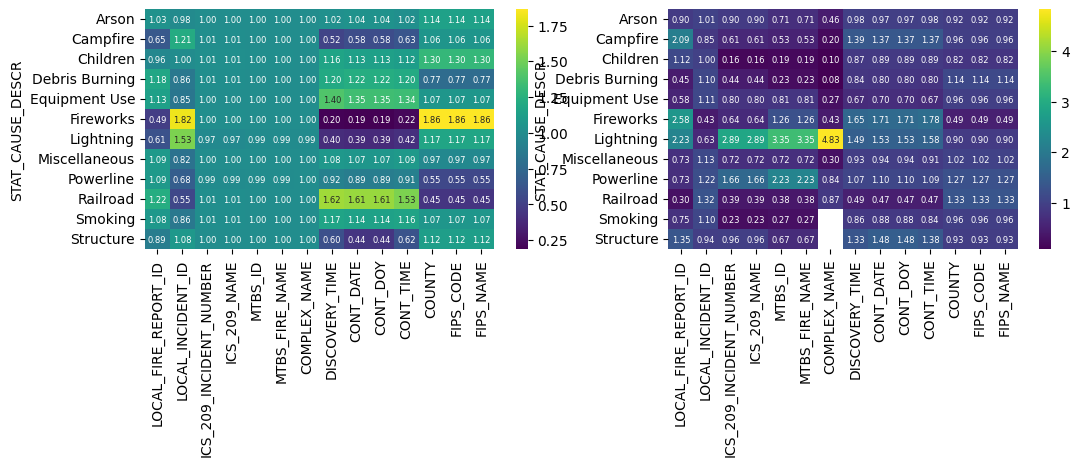

In [184]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))

# plot two plots
sns.heatmap(diff_value_count_label_distribution_df, annot=True, cmap='viridis', fmt='.2f', annot_kws={"fontsize":6}, ax=ax[0])
sns.heatmap(diff_value_count_not_null_label_distribution_df, annot=True, cmap='viridis', fmt='.2f', annot_kws={"fontsize":6}, ax=ax[1])

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


Let's see how null features are correlated

<Axes: >

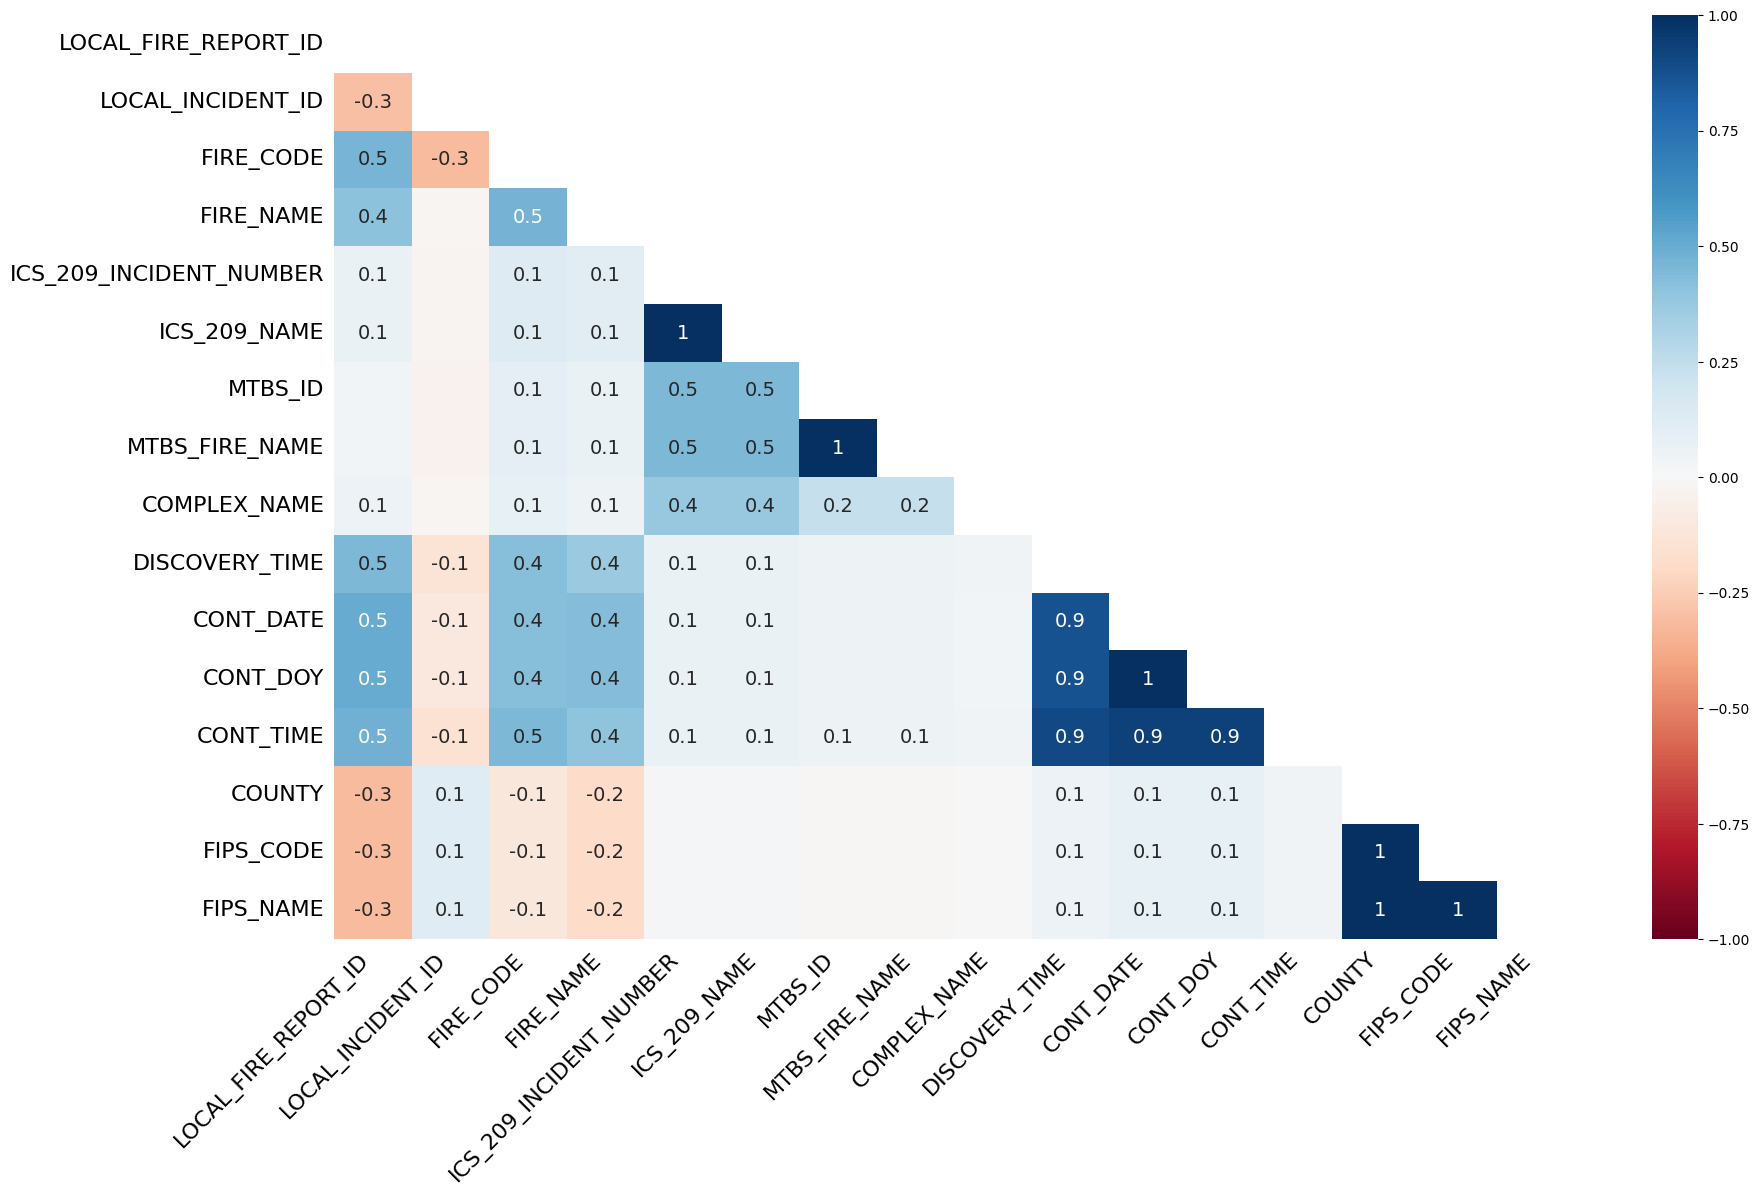

In [185]:
import missingno as msno
msno.heatmap(df)

## Feature Engineering

### Encoding

There are five columns that are 99% null, from EDA section, we see that if they are not null, it will help with the prediction of some columns.  
For other features, it seems like encode them as null or not null both have benefits.

In [186]:
# fucntion that will encode this four columns
def null_encoding(df):
  # these columns will be encoded as 1 - null, 0 - not null
  for feature in null_features:
    df['NE-'+feature] = df[feature].isnull().astype(int)
  return df


Little note here: we tried to pass some columns with empty values to the model, since XGB is able to fill in te blank. However, the train error will be lower but the validation error is higher.

### Imputation

There are a few columns that contains null in our training data. We will see if imputation help with accuracy.

In [187]:
def imputate_COUNTY(df):
  df["COUNTY"] = df["COUNTY"].str.lower()
  df.loc[df['COUNTY'].isnull(), 'COUNTY'] = df.loc[df['COUNTY'].isnull(),'STATE']
  return df

In [188]:
DELTA_TIME_means_by_class_map = {}
def train_DELTA_TIME_IMPUTATOR(df):
  global DELTA_TIME_means_by_class_map
  DELTA_TIME_means_by_class_map = df.groupby('FIRE_SIZE_CLASS')['DELTA_TIME'].agg(['mean'])['mean'].to_dict()

def fill_missing(row):
    if pd.isna(row['DELTA_TIME']):
        return DELTA_TIME_means_by_class_map[row['FIRE_SIZE_CLASS']]
    else:
        return row['DELTA_TIME']
def imputate_DELTA_TIME(df):
  df['DELTA_TIME'] = df.apply(fill_missing, axis=1)
  return df

It helps, reduce overfitting: validation error stays the same, but training error drops when left null.

### Drop Null rows

In [189]:
def drop_null_time_rows(X, y):
  df = X
  df['STAT_CAUSE_DESCR'] = y
  df = df.dropna(subset=['DISCOVERY_TIME']).copy()
  y = df['STAT_CAUSE_DESCR']
  X = df.drop(columns=['STAT_CAUSE_DESCR'])
  return X, y

# Preparation

In [190]:
# select features for trainin: This list depends on feature engineering
encoded_catagorical_features = ['FE-' + feature for feature in catagorical_features]
encoded_null_features = ['NE-'+ feature for feature in null_features]
selected_features = encoded_catagorical_features + encoded_null_features + geospacial_features + ['FIRE_SIZE']+ encoded_time_data +['STORM']

In [191]:
def transform_data_for_XGB(X, y, train = False):
  # null encoding: notice: encode null first because we might do some imputation later.
  X = null_encoding(X)

  # encode geospacial data
  if train==True:
    # train state encoding
    train_df = pd.concat([X, y], axis=1)
    train_state_encoders(train_df)
    #train clusters of coordinates
    train_target_class_clusters(train_df)
  X = encode_geospacial_data(X)

  # encode time data
  X = time_encoding(X)

  # add imputation
  if train==True:
    train_DELTA_TIME_IMPUTATOR(X)
  X = imputate_DELTA_TIME(X)
  X = imputate_COUNTY(X)


  if train==True:
    # train the frequency encoders
    train_frequency_encoders(X)
  # frequency encoding: notice: frequency encoding at the end!
  X = frequency_encoding(X)

  # additional imforamtion: encode storm information: Notice: have to be after time encoding
  X = encode_storm_data(X)

  # select feature for training
  X = X[selected_features]

  # change "object" dtypes to "category" types
  catagorial_columns = X.select_dtypes('object').columns.tolist()
  for col in catagorial_columns:
    X = X.astype({col:'category'})

  # encode y
  y = target_encoder.transform(y)
  return X, y


In [192]:
y_train_series = pd.Series(y_train, name="STAT_CAUSE_DESCR")
train_df = pd.concat([X_train, y_train_series], axis=1)
train_df = drop_outliers(train_df)
y_drop_outliers = train_df['STAT_CAUSE_DESCR']
X_drop_outliers = train_df.drop('STAT_CAUSE_DESCR', axis=1)

In [193]:
X_train_anomaly, y_train_anomaly = transform_data_for_XGB(X_drop_outliers, y_drop_outliers, train=True)

In [194]:
X_train, y_train = transform_data_for_XGB(X_train, y_train, train=True)
X_val, y_val = transform_data_for_XGB(X_val, y_val)

In [195]:
# save the files to drive, so that we can switch to GPU
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
dump_file(y_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
dump_file(X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
dump_file(y_val, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
dump_file(target_encoder, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')
dump_file(X_test,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_test.csv')
dump_file(y_test,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_test.csv')

dump_file(X_train_anomaly,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train_anomaly.csv')

dump_file(y_train_anomaly,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train_anomaly.csv')


# Training XGBoost

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')


In [2]:
from xgboost import XGBClassifier
# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
    # "max_cat_to_onehot": 4
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save the model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')


[0]	validation_0-mlogloss:2.02332	validation_1-mlogloss:2.02584
[1]	validation_0-mlogloss:1.83757	validation_1-mlogloss:1.84275
[2]	validation_0-mlogloss:1.71711	validation_1-mlogloss:1.72411
[3]	validation_0-mlogloss:1.63244	validation_1-mlogloss:1.64144
[4]	validation_0-mlogloss:1.56858	validation_1-mlogloss:1.57952
[5]	validation_0-mlogloss:1.52065	validation_1-mlogloss:1.53328
[6]	validation_0-mlogloss:1.48242	validation_1-mlogloss:1.49679
[7]	validation_0-mlogloss:1.45169	validation_1-mlogloss:1.46785
[8]	validation_0-mlogloss:1.42736	validation_1-mlogloss:1.44517
[9]	validation_0-mlogloss:1.40720	validation_1-mlogloss:1.42700
[10]	validation_0-mlogloss:1.39021	validation_1-mlogloss:1.41185
[11]	validation_0-mlogloss:1.37485	validation_1-mlogloss:1.39831
[12]	validation_0-mlogloss:1.36299	validation_1-mlogloss:1.38825
[13]	validation_0-mlogloss:1.35186	validation_1-mlogloss:1.37893
[14]	validation_0-mlogloss:1.34215	validation_1-mlogloss:1.37112
[15]	validation_0-mlogloss:1.33404	

# Other attempts

## AUC

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import numpy as np

# auc score
def auc_ovr(y_val, y_score):
  return roc_auc_score(y_val, y_score, multi_class='ovr', average="weighted")

# f1 ovr score
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(y_pred, axis=1)
    return 'f1_score', f1_score(y_true, y_pred, average='macro')


In [4]:
from xgboost import XGBClassifier

# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
    "eval_metric": auc_ovr,
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-auc.json')

[0]	validation_0-mlogloss:2.02332	validation_0-auc_ovr:0.80917	validation_1-mlogloss:2.02584	validation_1-auc_ovr:0.80656
[1]	validation_0-mlogloss:1.83757	validation_0-auc_ovr:0.82157	validation_1-mlogloss:1.84275	validation_1-auc_ovr:0.81815
[2]	validation_0-mlogloss:1.71711	validation_0-auc_ovr:0.82766	validation_1-mlogloss:1.72411	validation_1-auc_ovr:0.82400
[3]	validation_0-mlogloss:1.63244	validation_0-auc_ovr:0.83157	validation_1-mlogloss:1.64144	validation_1-auc_ovr:0.82758
[4]	validation_0-mlogloss:1.56858	validation_0-auc_ovr:0.83516	validation_1-mlogloss:1.57952	validation_1-auc_ovr:0.83075
[5]	validation_0-mlogloss:1.52065	validation_0-auc_ovr:0.83765	validation_1-mlogloss:1.53328	validation_1-auc_ovr:0.83298
[6]	validation_0-mlogloss:1.48242	validation_0-auc_ovr:0.83996	validation_1-mlogloss:1.49679	validation_1-auc_ovr:0.83499
[7]	validation_0-mlogloss:1.45169	validation_0-auc_ovr:0.84215	validation_1-mlogloss:1.46785	validation_1-auc_ovr:0.83688
[8]	validation_0-mloglos

## F1 score

In [5]:
# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)],eval_metric=f1_eval)
# save model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-f1.json')

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.02332	validation_0-f1_score:0.32230	validation_1-mlogloss:2.02584	validation_1-f1_score:0.31748
[1]	validation_0-mlogloss:1.83757	validation_0-f1_score:0.33117	validation_1-mlogloss:1.84275	validation_1-f1_score:0.32340
[2]	validation_0-mlogloss:1.71711	validation_0-f1_score:0.33858	validation_1-mlogloss:1.72411	validation_1-f1_score:0.33170
[3]	validation_0-mlogloss:1.63244	validation_0-f1_score:0.34219	validation_1-mlogloss:1.64144	validation_1-f1_score:0.33500
[4]	validation_0-mlogloss:1.56858	validation_0-f1_score:0.34510	validation_1-mlogloss:1.57952	validation_1-f1_score:0.33627
[5]	validation_0-mlogloss:1.52065	validation_0-f1_score:0.34641	validation_1-mlogloss:1.53328	validation_1-f1_score:0.33961
[6]	validation_0-mlogloss:1.48242	validation_0-f1_score:0.34956	validation_1-mlogloss:1.49679	validation_1-f1_score:0.34132
[7]	validation_0-mlogloss:1.45169	validation_0-f1_score:0.35169	validation_1-mlogloss:1.46785	validation_1-f1_score:0.34348
[8]	vali

## Balancing data

In [7]:
import numpy as np
def calculate_sample_weights(y_train):
  class_counts = np.bincount(y_train)
  total_example = np.sum(class_counts)
  class_weights = total_example/(len(class_counts)* class_counts)
  sample_weights = class_weights[y_train]
  return sample_weights

In [8]:
sample_weights = calculate_sample_weights(y_train)

In [9]:
# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
    'sample_weight':sample_weights
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-balanced.json')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:45:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.02332	validation_1-mlogloss:2.02584
[1]	validation_0-mlogloss:1.83757	validation_1-mlogloss:1.84275
[2]	validation_0-mlogloss:1.71711	validation_1-mlogloss:1.72411
[3]	validation_0-mlogloss:1.63244	validation_1-mlogloss:1.64144
[4]	validation_0-mlogloss:1.56858	validation_1-mlogloss:1.57952
[5]	validation_0-mlogloss:1.52065	validation_1-mlogloss:1.53328
[6]	validation_0-mlogloss:1.48242	validation_1-mlogloss:1.49679
[7]	validation_0-mlogloss:1.45169	validation_1-mlogloss:1.46785
[8]	validation_0-mlogloss:1.42736	validation_1-mlogloss:1.44517
[9]	validation_0-mlogloss:1.40720	validation_1-mlogloss:1.42700
[10]	validation_0-mlogloss:1.39021	validation_1-mlogloss:1.41185
[11]	validation_0-mlogloss:1.37485	validation_1-mlogloss:1.39831
[12]	validation_0-mlogloss:1.36299	validation_1-mlogloss:1.38825
[13]	validation_0-mlogloss:1.35186	validation_1-mlogloss:1.37893
[14]	validation_0-mlogloss:1.34215	validation_1-mlogloss:1.37112
[15]	validation_0-mlogloss:1.33404	

## Anomaly Detection

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train_anomaly.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train_anomaly.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')


In [2]:
from xgboost import XGBClassifier

# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
# save model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-anomaly.json')

[0]	validation_0-mlogloss:2.01835	validation_1-mlogloss:2.08781
[1]	validation_0-mlogloss:1.82724	validation_1-mlogloss:1.91495
[2]	validation_0-mlogloss:1.70395	validation_1-mlogloss:1.79962
[3]	validation_0-mlogloss:1.61647	validation_1-mlogloss:1.71962
[4]	validation_0-mlogloss:1.55234	validation_1-mlogloss:1.66084
[5]	validation_0-mlogloss:1.50125	validation_1-mlogloss:1.61438
[6]	validation_0-mlogloss:1.46243	validation_1-mlogloss:1.57879
[7]	validation_0-mlogloss:1.43128	validation_1-mlogloss:1.55023
[8]	validation_0-mlogloss:1.40603	validation_1-mlogloss:1.52761
[9]	validation_0-mlogloss:1.38516	validation_1-mlogloss:1.50838
[10]	validation_0-mlogloss:1.36814	validation_1-mlogloss:1.49507
[11]	validation_0-mlogloss:1.35343	validation_1-mlogloss:1.48321
[12]	validation_0-mlogloss:1.34107	validation_1-mlogloss:1.47391
[13]	validation_0-mlogloss:1.33026	validation_1-mlogloss:1.46570
[14]	validation_0-mlogloss:1.32063	validation_1-mlogloss:1.45844
[15]	validation_0-mlogloss:1.31148	

## Feature Selection

We will just run a simple feature selection here.

In [9]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')


In [10]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')



In [11]:
import numpy as np
# Get feature importances
feature_importances = clf.feature_importances_

# Sort features based on importance
sorted_idx = np.argsort(feature_importances)[::-1]

# let's look at what features are more importamt
column_names = [X_train.columns[i] for i in sorted_idx]
column_names

['SE-Lightning',
 'SE-Debris Burning',
 'SE-Arson',
 'SE-Miscellaneous',
 'FE-SOURCE_SYSTEM_TYPE',
 'SE-Equipment Use',
 'SE-Railroad',
 'SE-Campfire',
 'FE-SOURCE_SYSTEM',
 'SE-Children',
 'STORM',
 'NE-LOCAL_FIRE_REPORT_ID',
 'NE-CONT_TIME',
 'FE-OWNER_CODE',
 'FE-NWCG_REPORTING_AGENCY',
 'FE-NWCG_REPORTING_UNIT_NAME',
 'SE-Fireworks',
 'SE-Smoking',
 'SE-Powerline',
 'FE-SOURCE_REPORTING_UNIT_NAME',
 'FE-NWCG_REPORTING_UNIT_ID',
 'NE-DISCOVERY_TIME',
 'MONTH',
 'DELTA_TIME',
 'SE-Structure',
 'LONGITUDE',
 'independence_day',
 'FE-SOURCE_REPORTING_UNIT',
 'FIRE_SIZE',
 'NE-LOCAL_INCIDENT_ID',
 'LATITUDE',
 'FE-FIRE_SIZE_CLASS',
 'FE-STATE',
 'COS_DISCOVERY_DOY',
 'COS_HOUR',
 'NE-CONT_DATE',
 'FE-FIRE_YEAR',
 'DISTANCE_TO_CLUSTERS-Fireworks',
 'DISTANCE_TO_CLUSTERS-Structure',
 'NE-COMPLEX_NAME',
 'DISTANCE_TO_CLUSTERS-Debris Burning',
 'DISTANCE_TO_CLUSTERS-Lightning',
 'DISTANCE_TO_CLUSTERS-Arson',
 'DISTANCE_TO_CLUSTERS-Miscellaneous',
 'DISTANCE_TO_CLUSTERS-Children',
 'DISTANCE

In [12]:
# Select top 30 out of 75 features
top_n_features = sorted_idx[:30]
new_X_train = X_train.iloc[:, top_n_features]
new_X_val = X_val.iloc[:, top_n_features]



In [13]:
import pickle
def dump_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
dump_file(new_X_train,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/new_X_train.csv')
dump_file(new_X_val,'/content/drive/MyDrive/Projects/FirePrediction/tempFiles/new_X_val.csv')


In [14]:
# define hyper parameters
params = {
    "device": "cuda",
    "enable_categorical": True,
     "n_estimators": 300,
}
# create model instance
clf = XGBClassifier(**params,)
# fit model
clf.fit(new_X_train, y_train, eval_set=[(new_X_train, y_train), (new_X_val, y_val)])
# save the model
clf.save_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-feature.json')


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:22:59] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:2.03202	validation_1-mlogloss:2.03370
[1]	validation_0-mlogloss:1.85158	validation_1-mlogloss:1.85461
[2]	validation_0-mlogloss:1.73616	validation_1-mlogloss:1.74015


# Evaluation XGBoost

In [1]:
import pandas as pd
import pickle
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
    return obj
X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_train.csv')
y_train= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_val.csv')
y_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_val.csv')
target_encoder = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/target_encoder')
X_test= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/X_test.csv')
y_test =load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/y_test.csv')

In [2]:
for i in range(12):
  class_name = target_encoder.inverse_transform([i])[0]
  print(f'{i}: {class_name}')

0: Arson
1: Campfire
2: Children
3: Debris Burning
4: Equipment Use
5: Fireworks
6: Lightning
7: Miscellaneous
8: Powerline
9: Railroad
10: Smoking
11: Structure


In [3]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function that will print the preformance for each class
def plot_auc_by_class(y_val, y_pred_prob, ovr_auc, model_name):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  label_binarizer = LabelBinarizer()

  for i in range(y_pred_prob.shape[1]):
    y_true_class = label_binarizer.fit_transform(y_val == i)
    # Calculate ROC curve and AUC for the current class
    fpr[i], tpr[i], _ = roc_curve(y_true_class[:, 0], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  # Plot ROC curves for each class
  plt.figure(figsize=(10, 8))

  for i in range(y_pred_prob.shape[1]):
      class_name = target_encoder.inverse_transform([i])[0]
      plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
  plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot diagonal line for reference
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for Each Class (Score: {ovr_auc}, model: {model_name})')
  plt.legend(loc='lower right')
  plt.show()

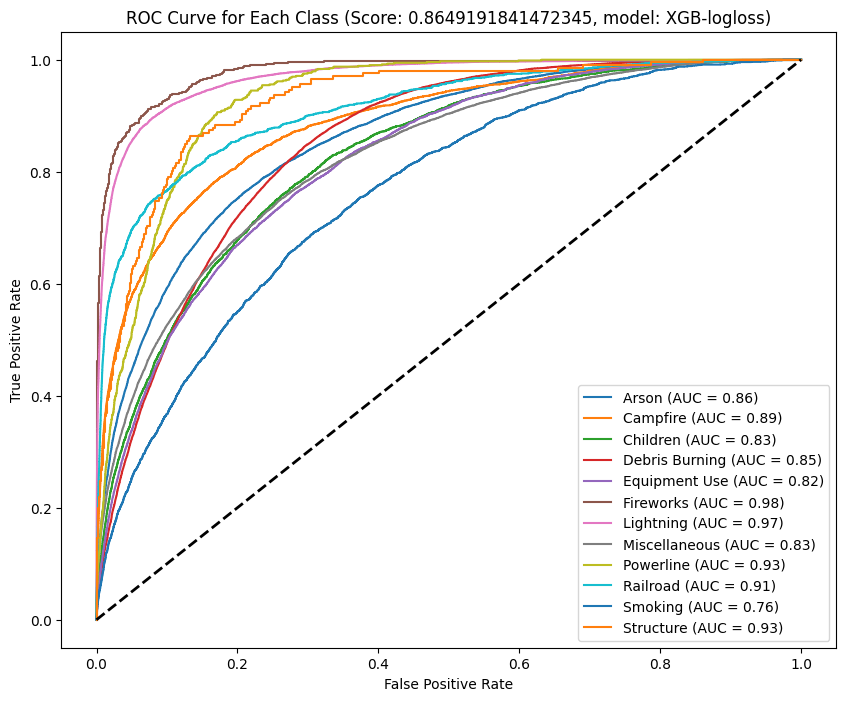

In [ ]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb.json')

y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss')

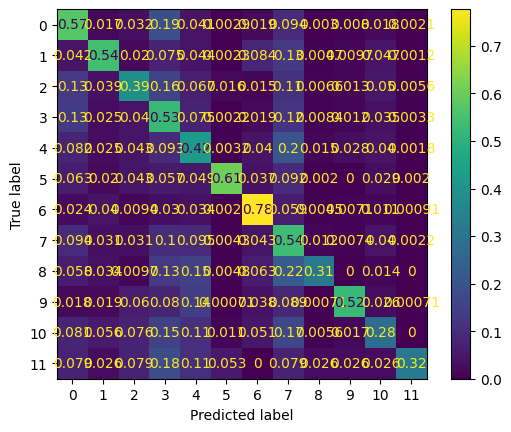

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

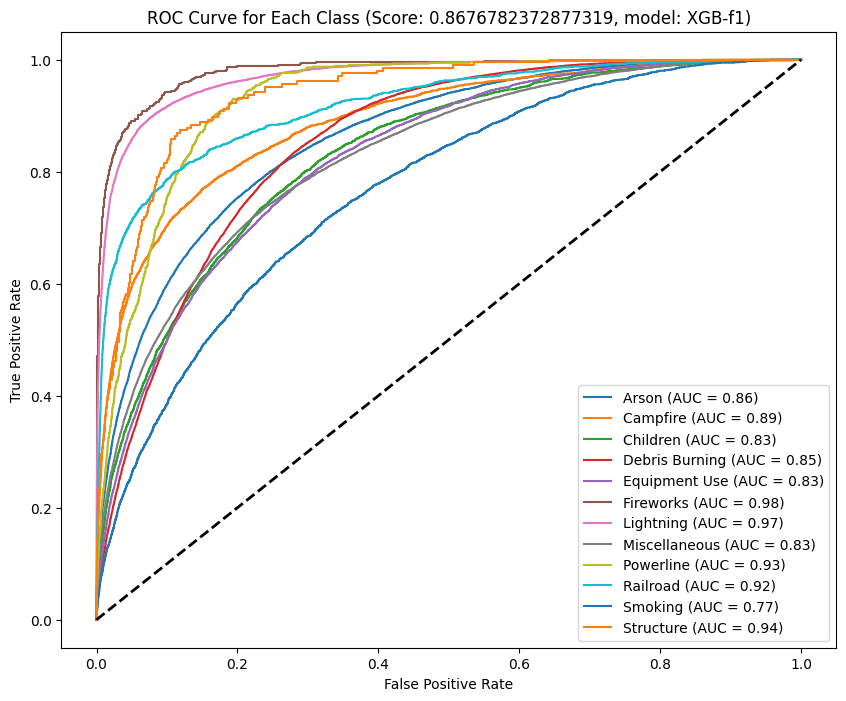

In [ ]:
from sklearn.metrics import roc_auc_score
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-f1.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-f1')

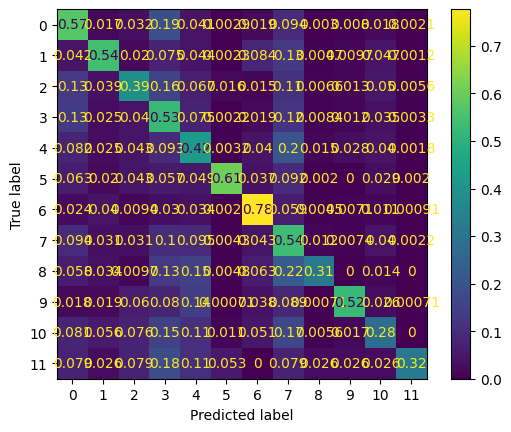

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

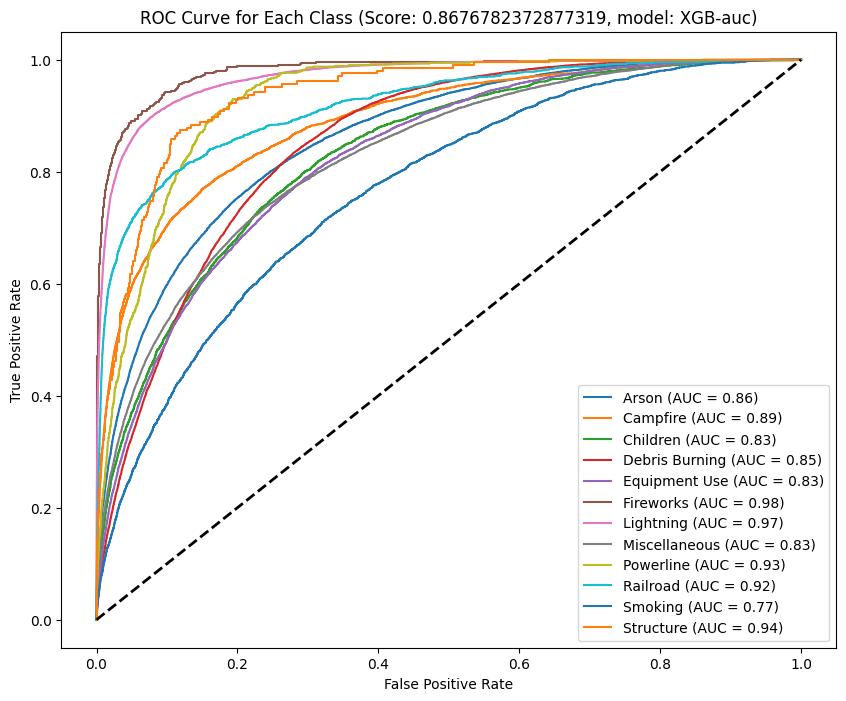

In [ ]:
from sklearn.metrics import roc_auc_score
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-auc.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-auc')

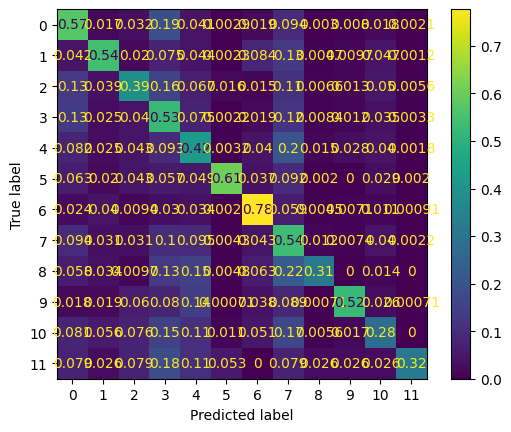

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

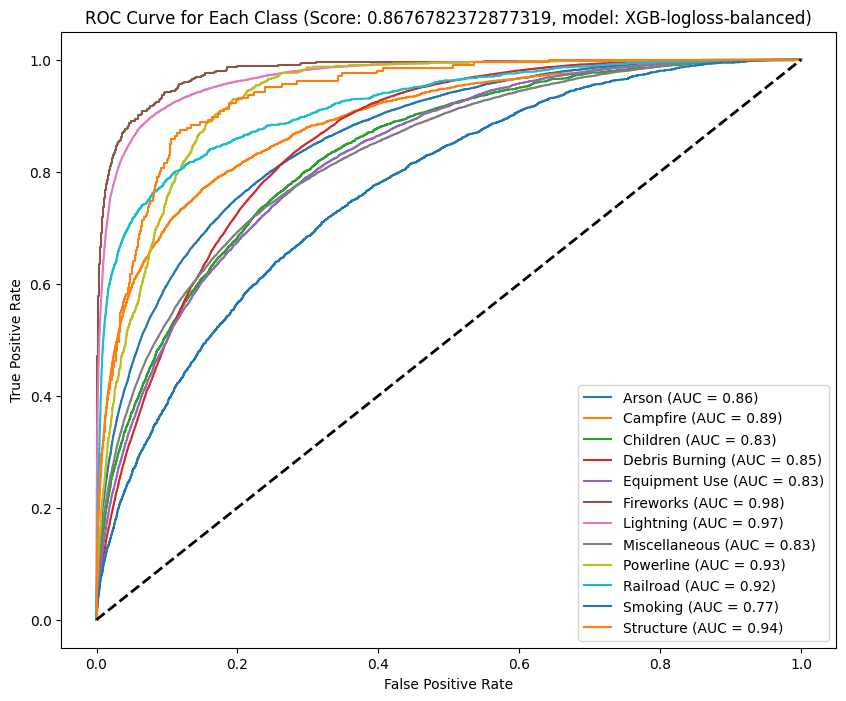

In [ ]:
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-balanced.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss-balanced')

In [ ]:
# encoded_target_class = target_encoder.transform(target_classes)
# target_encoded_df = pd.DataFrame({"OrignalLabel": target_classes, "Encoded": encoded_target_class, "Class Count": class_counts, "Class weight": class_weights})
# dump_file(sample_weights, '/content/drive/MyDrive/Projects/FirePrediction/tempFiles/sample_weights')

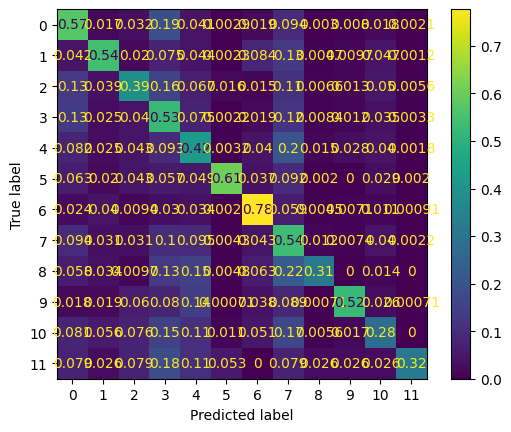

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

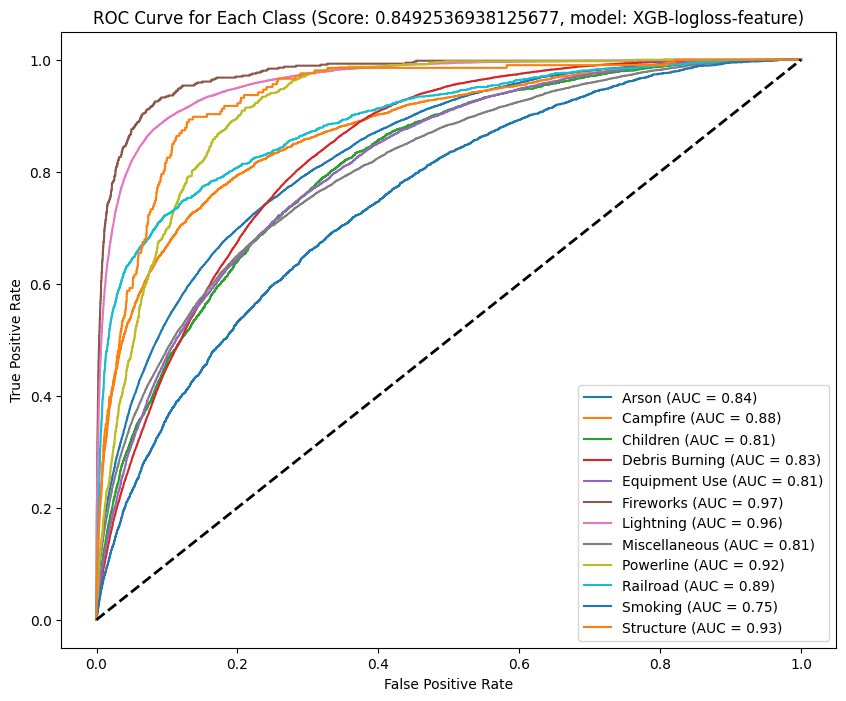

In [ ]:
clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-feature.json')

X_train = load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/new_X_train.csv')
X_val= load_file('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/new_X_val.csv')

y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-logloss-feature')

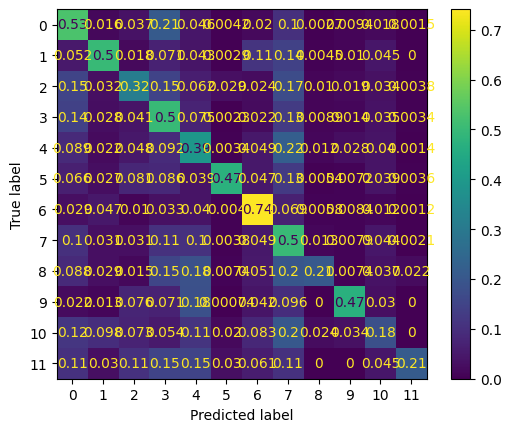

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')

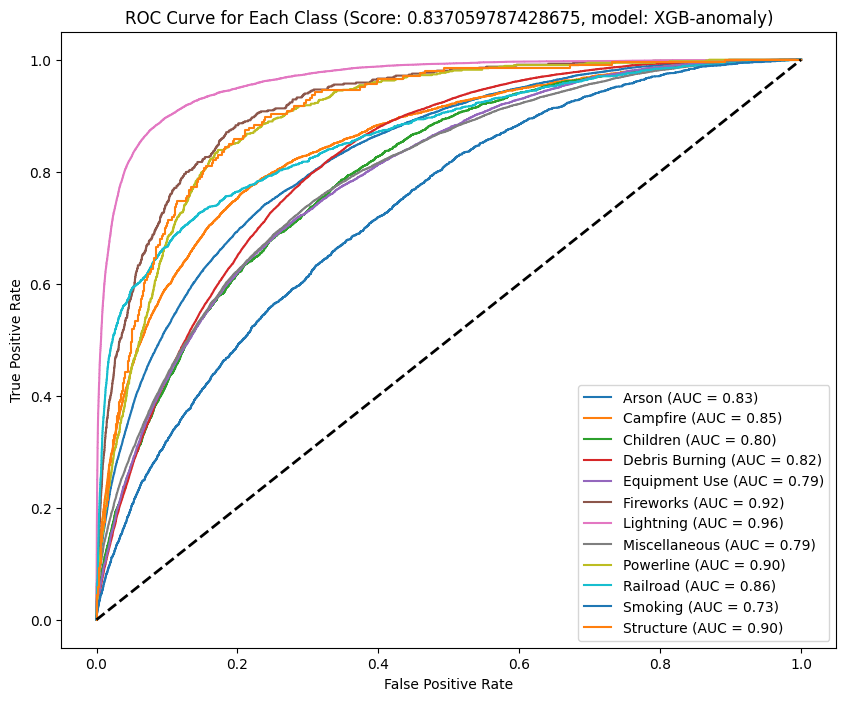

In [5]:
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.load_model('/content/drive/MyDrive/Projects/FirePrediction/tempFiles/xgb-anomaly.json')
y_pred_prob = clf.predict_proba(X_val)  # proba of positive samples
ovr_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr',average="weighted")
plot_auc_by_class(y_val, y_pred_prob, ovr_auc, 'XGB-anomaly')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(clf.predict(X_val),y_val, normalize='true')